PHASE 1: Business Understanding

Monopoly Bank, with years of experience serving clients in Chile, has recently been acquired by foreign bank Dormammu. This strategic change aims to leverage the Chilean market and optimize relationships with Monopoly's clients through a deep analysis of their financial behavior.
As part of Dormammu's engineering team, we have been tasked with analyzing a database provided by Monopoly. This contains detailed 12-month information for 51,124 clients, organized across 574 variables including demographic, financial, and behavioral characteristics. The main objective is to extract patterns, identify segments, and generate valuable inputs to design strategies that enhance client management under the new administration.
Objective
To understand Monopoly Bank clients' behavior through analysis of their historical data, to provide key insights that will guide Dormammu's commercial and operational strategy.
Key Questions
How do sociodemographic factors, such as region, income, and age, influence the use of financial products?
Do clients with multiple financial products (duality) generate more revenue and transactions than single-product clients?
3. How does client tenure with the bank affect their activity level and use of credit lines?
What behavioral patterns can be identified in credit and debit card usage according to client subsegment?
CRISP-DM Model
In this work, we will base our Machine Learning process on the CRISP-DM analytical model. This model has the advantage of being flexible, easy to understand, and adaptable to the vast majority of projects. CRISP-DM consists of 6 phases, which are:
Business Understanding: Clearly define the context and business objectives.
Data Understanding: Explore, describe, and analyze the data from the DataSets to identify quality issues or important patterns.
Data Preparation: Clean, transform, and select relevant data for analysis.
Modeling: Apply data mining algorithms and techniques (such as decision trees, regression, etc.) to build models that solve the business problem.
Evaluation: Verify if the created models are useful and meet the business objectives, adjusting if necessary.
6. Deployment: Implement the model in a real environment, whether to automate decisions, generate reports, or any other required business application.

DESCRIPTION TABLE

| Variable | Transformación | Valor | Descripcion |
|----------|----------------|-------|-------------|
| CORRELATIVO | Ninguna | 518050 | Identificador cliente |
| Region | Ninguna | 13 | Region de Residencia |
| Renta | Ninguna | NULL | Renta del cliente |
| Sexo | Ninguna | M | Sexo |
| Subsegmento | Ninguna | 151 | Subsegmento |
| Edad | Ninguna | 39 | Edad |
| Adicional | Ninguna | 0 | Indicador de Tenecia de TC adicionales |
| Antiguedad | Ninguna | 78 | Antigüedad del cliente (meses) |
| CambioPin | Ninguna | NULL | Indicador del cambio de clave secreta de la tarjeta |
| Consumo | Ninguna | 0 | Indicador de Credito de Consumo |
| Debito | Ninguna | 1 | Indicador de Tenecia de TD |
| Ctacte | Ninguna | 1 | Indicador de Cuenta Corriente |
| Cuentas | Ninguna | 1 | Numero de cuentas que tiene el cliente |
| Hipotecario | Ninguna | 0 | Indicador de Credito Hipotecario |
| Internauta | Ninguna | 1 | Indicador de cliente Internauta que usa la web Monopoly |
| Monoproducto | Ninguna | 0 | Indicador de si el cliente es solo poseedor de una TC |
| TC | Ninguna | 1 | Numero de TC que tiene el cliente |
| Dualidad | Ninguna | 0 | Indicador de Dualidad (Cliente es dual si tiene 2 o mas TC) |
| CUPO_L1 | Ninguna | 1800000 | Cupo de la tarjeta credito para compras nacionales |
| CUPO_MX | Ninguna | 3750 | Cupo de la tarjeta credito para compras internacionales |
| CUPO_L2 | Ninguna | 1 | Cupo de la tarjeta credito para avances en cuotas |
| Col_T12 | promedio | 0 | Colocacion del cliente en TC en el mes X |
| ColL1TE_T12 | | 0 | Revolving del cliente en TC en el mes X |
| EeccInt_T12 | promedio | 0 | Monto internacional exigido en el estado de cuenta del cliente en el mes X |
| EeccNac_T12 | promedio | -12178 | Monto nacional exigido en el estado de cuenta del cliente en el mes X |
| Fac_T12 | Promedio | 0 | Monto facturado por el cliente en TC en el mes X |
| FacAI_T12 | Promedio | 0 | Monto facturado en avances internacionales por el cliente en TC en el mes X |
| FacAN_T12 | Promedio | 0 | Monto facturado en avances nacionales por el cliente en TC en el mes X |
| FacCCOT_T12 | Promedio | 0 | Monto facturado en compras en cuotas con tasa por el cliente en TC en el mes X |
| FacCCPC_T12 | Promedio | 0 | Monto facturado en compras en cuotas precio contado por el cliente en TC en el mes X |
| FacCI_T12 | Promedio | 0 | Monto facturado en compras internacionales por el cliente en TC en el mes X |
| FacCN_T12 | Promedio | 0 | Monto facturado en compras nacionales por el cliente en TC en el mes X |
| FacCOL_T12 | Promedio | 0 | Monto facturado en avances en cuotas por el cliente en TC en el mes X |
| FacDebAtm_T12 | Promedio | 800000 | Monto facturado en avances por el cliente en TD en el mes X |
| FacDebCom_T12 | Promedio | 221730 | Monto facturado en compras por el cliente en TD en el mes X |
| FacPAT_T12 | Promedio | 0 | Monto facturado en PAT por el cliente en TC en el mes X |
| FlgAct_T12 | Suma meses activos | 0 | Indicador de actividad en el mes X en la TC |
| FlgActAI_T12 | Suma meses activos | 0 | Indicador de actividad en avances internacionales en el mes X en la TC |
| FlgActAN_T12 | Suma meses activos | 0 | Indicador de actividad en avances nacionales en el mes X en la TC |
| FlgActCCOT_T12 | Suma meses activos | 0 | Indicador de actividad en compras nacionales en cuotas con tasa en el mes X en la TC |
| FlgActCCPC_T12 | Suma meses activos | 0 | Indicador de actividad en compras nacionales en cuotas precio contado en el mes X en la TC |
| FlgActCI_T12 | Suma meses activos | 0 | Indicador de actividad en compras internacionales en el mes X en la TC |
| FlgActCN_T12 | Suma meses activos | 0 | Indicador de actividad en compras nacionales en el mes X en la TC |
| FlgActCOL_T12 | Suma meses activos | 0 | Indicador de actividad en avances en cuotas con tasa en el mes X en la TC |
| FlgActPAT_T12 | Suma meses activos | 0 | Indicador de actividad en PAT en el mes X en la TC |
| PagoInt_T12 | promedio | 0 | Monto de pagos de deuda internacional del cliente en el mes X |
| PagoNac_T12 | promedio | 25000 | Monto de pagos de deuda nacional del cliente en el mes X |
| Txs_T12 | Suma | 0 | Numero de transacciones realizados por el cliente en TC en el mes X |
| TxsAI_T12 | Suma | 0 | Numero de transacciones en avances internacionales realizados por el cliente en TC en el mes X |
| TxsAN_T12 | Suma | 0 | Numero de transacciones en avances nacionales realizados por el cliente en TC en el mes X |
| TxsCCOT_T12 | Suma | 0 | Numero de transacciones en compras en cuotas con tasa realizados por el cliente en TC en el mes X |
| TxsCCPC_T12 | Suma | 0 | Numero de transacciones en compras en cuotas precio contado realizados por el cliente en TC en el mes X |
| TxsCI_T12 | Suma | 0 | Numero de transacciones en compras internacionales realizados por el cliente en TC en el mes X |
| TxsCN_T12 | Suma | 0 | Numero de transacciones en compras nacionales realizados por el cliente en TC en el mes X |
| TxsCOL_T12 | Suma | 0 | Numero de transacciones en avances en cuotas por el cliente en TC en el mes X |
| TxsDebAtm_T12 | Suma | 5 | Numero de transacciones en avances realizados por el cliente en TD en el mes X |
| TxsDebCom_T12 | Suma | 9 | Numero de transacciones en compras realizados por el cliente en TD en el mes X |
| TxsPAT_T12 | Suma | 0 | Numero de transacciones en PAT realizados por el cliente en TC en el mes X |
| UsoL1_T12 | Promedio | -12178 | Monto de deuda en la linea de compras en la TC en el mes X |
| UsoL2_T12 | Promedio | 0 | Monto de deuda en la linea de avances en cuotas en la TC en el mes X |
| UsoLI_T12 | Promedio | 0 | Monto de deuda en la linea de compras internacionales en la TC en el mes X |

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix
)
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression, make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score, silhouette_samples



In [2]:
ds = pd.read_excel('../data/01_raw/Base_clientes_Monopoly.xlsx')

To begin with the exploratory analysis, it is essential to identify and understand the information contained in each of the datasets we will be using. Below is a summary of the three main datasets involved in our study.

The proposed dataset has errors so, before anything else, we will apply a function that orders the shape of the sataset to be able to work with it

In [3]:
ds.columns = ds.iloc[0]  
ds = ds[1:]
ds.reset_index(drop=True, inplace=True)

In the data preparation process, the first row of the DataFrame `db` is assigned as the column names since the original Excel file contained numbers instead of descriptive names. This is crucial for facilitating the identification and handling of the data in subsequent analyses. Next, this first row is removed from the DataFrame, ensuring that only the relevant data remains for analysis and avoiding confusion from duplicate data. Following this, the index of the DataFrame is reset to keep it clean and organized, which is a good practice in data preparation. Finally, the new column names and the first few rows of the DataFrame are printed to verify that the operations have been executed correctly. This verification is essential in the CRISP-DM methodology to ensure that the data is properly structured before proceeding with exploratory analysis and modeling.

PHASE 2: Data Understanding

In [4]:
ds.describe()

,NaN
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


Now, we know that the dataset have so many errors about NaN data

In [5]:
ds.isna().sum()


0
Id                 0
Subsegmento        0
Sexo               1
Region            53
Edad               0
               ...  
UsoL2_T01          0
UsoLI_T01          0
IndRev_T01         0
target             0
NaN            51124
Length: 575, dtype: int64

We find out how many nulls exist in the table

In [6]:
print(ds.dtypes)

0
Id              object
Subsegmento     object
Sexo            object
Region          object
Edad            object
                ...   
UsoL2_T01       object
UsoLI_T01       object
IndRev_T01      object
target          object
NaN            float64
Length: 575, dtype: object


The types of data contained in the columns in the dataset

In [7]:
print(len(ds.columns))

575


the total number of columns of the dataset

In [9]:
ds.count()



0
Id             51124
Subsegmento    51124
Sexo           51123
Region         51071
Edad           51124
               ...  
UsoL2_T01      51124
UsoLI_T01      51124
IndRev_T01     51124
target         51124
NaN                0
Length: 575, dtype: int64

the total number of row of the dataset

In [10]:
total_number_rows = ds.shape[0]

print(f'Total number of rows: {total_number_rows}')
print(f'Dataset dimensions: {ds.shape}')

Total number of rows: 51124
Dataset dimensions: (51124, 575)


In [11]:
description = ds.describe()
for column in description.columns:
    print(f"Analysis of {column}:")

    mean_value = description[column].mean(skipna=True)
    print(f" - Mean (Average): {mean_value:.2f} ")

    median_value = description[column].median(skipna=True)
    print(f" - Median: {median_value:.2f} ")

Analysis of nan:
 - Mean (Average): 0.00 
 - Median: 0.00 


Now that we have visualized the raw dataset data, we can start trimming and modifying the data to be able to work with it in an optimal way.

Fase 3: Data Preparation

In [12]:
columns = [
    'Id', 'Region', 'Renta', 'Sexo', 'Subsegmento', 'Edad', 
    'Adicional', 'Antiguedad', 'CambioPin', 'Consumo', 'Debito', 'Ctacte', 
    'Cuentas', 'Hipotecario', 'Internauta', 'Monoproducto', 'TC', 'Dualidad', 
    'CUPO_L1', 'CUPO_MX', 'CUPO_L2', 'Col_T12', 'ColL1TE_T12', 'EeccInt_T12', 
    'EeccNac_T12', 'Fac_T12', 'FacAI_T12', 'FacAN_T12', 'FacCCOT_T12', 
    'FacCCPC_T12', 'FacCI_T12', 'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 
    'FacDebCom_T12', 'FacPAT_T12', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12', 
    'FlgActCCOT_T12', 'FlgActCCPC_T12', 'FlgActCI_T12', 'FlgActCN_T12', 
    'FlgActCOL_T12', 'FlgActPAT_T12', 'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 
    'TxsAI_T12', 'TxsAN_T12', 'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12', 
    'TxsCN_T12', 'TxsCOL_T12', 'TxsDebAtm_T12', 'TxsDebCom_T12', 'TxsPAT_T12', 
    'UsoL1_T12', 'UsoL2_T12', 'UsoLI_T12'
]
ds = ds[columns]

In [13]:
we select the columns that serve us

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ we select the columns that serve us                                                              │
│    ▲                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [14]:
for col in ds.columns:
    if col != 'Sexo':
        ds[col] = pd.to_numeric(ds[col], errors='coerce')

converts all columns in the dataset to numeric format, except for the 'Sexo' (Gender) column. It uses pandas' to_numeric function with error handling that converts invalid values to NaN.

Numeric variables distributions:


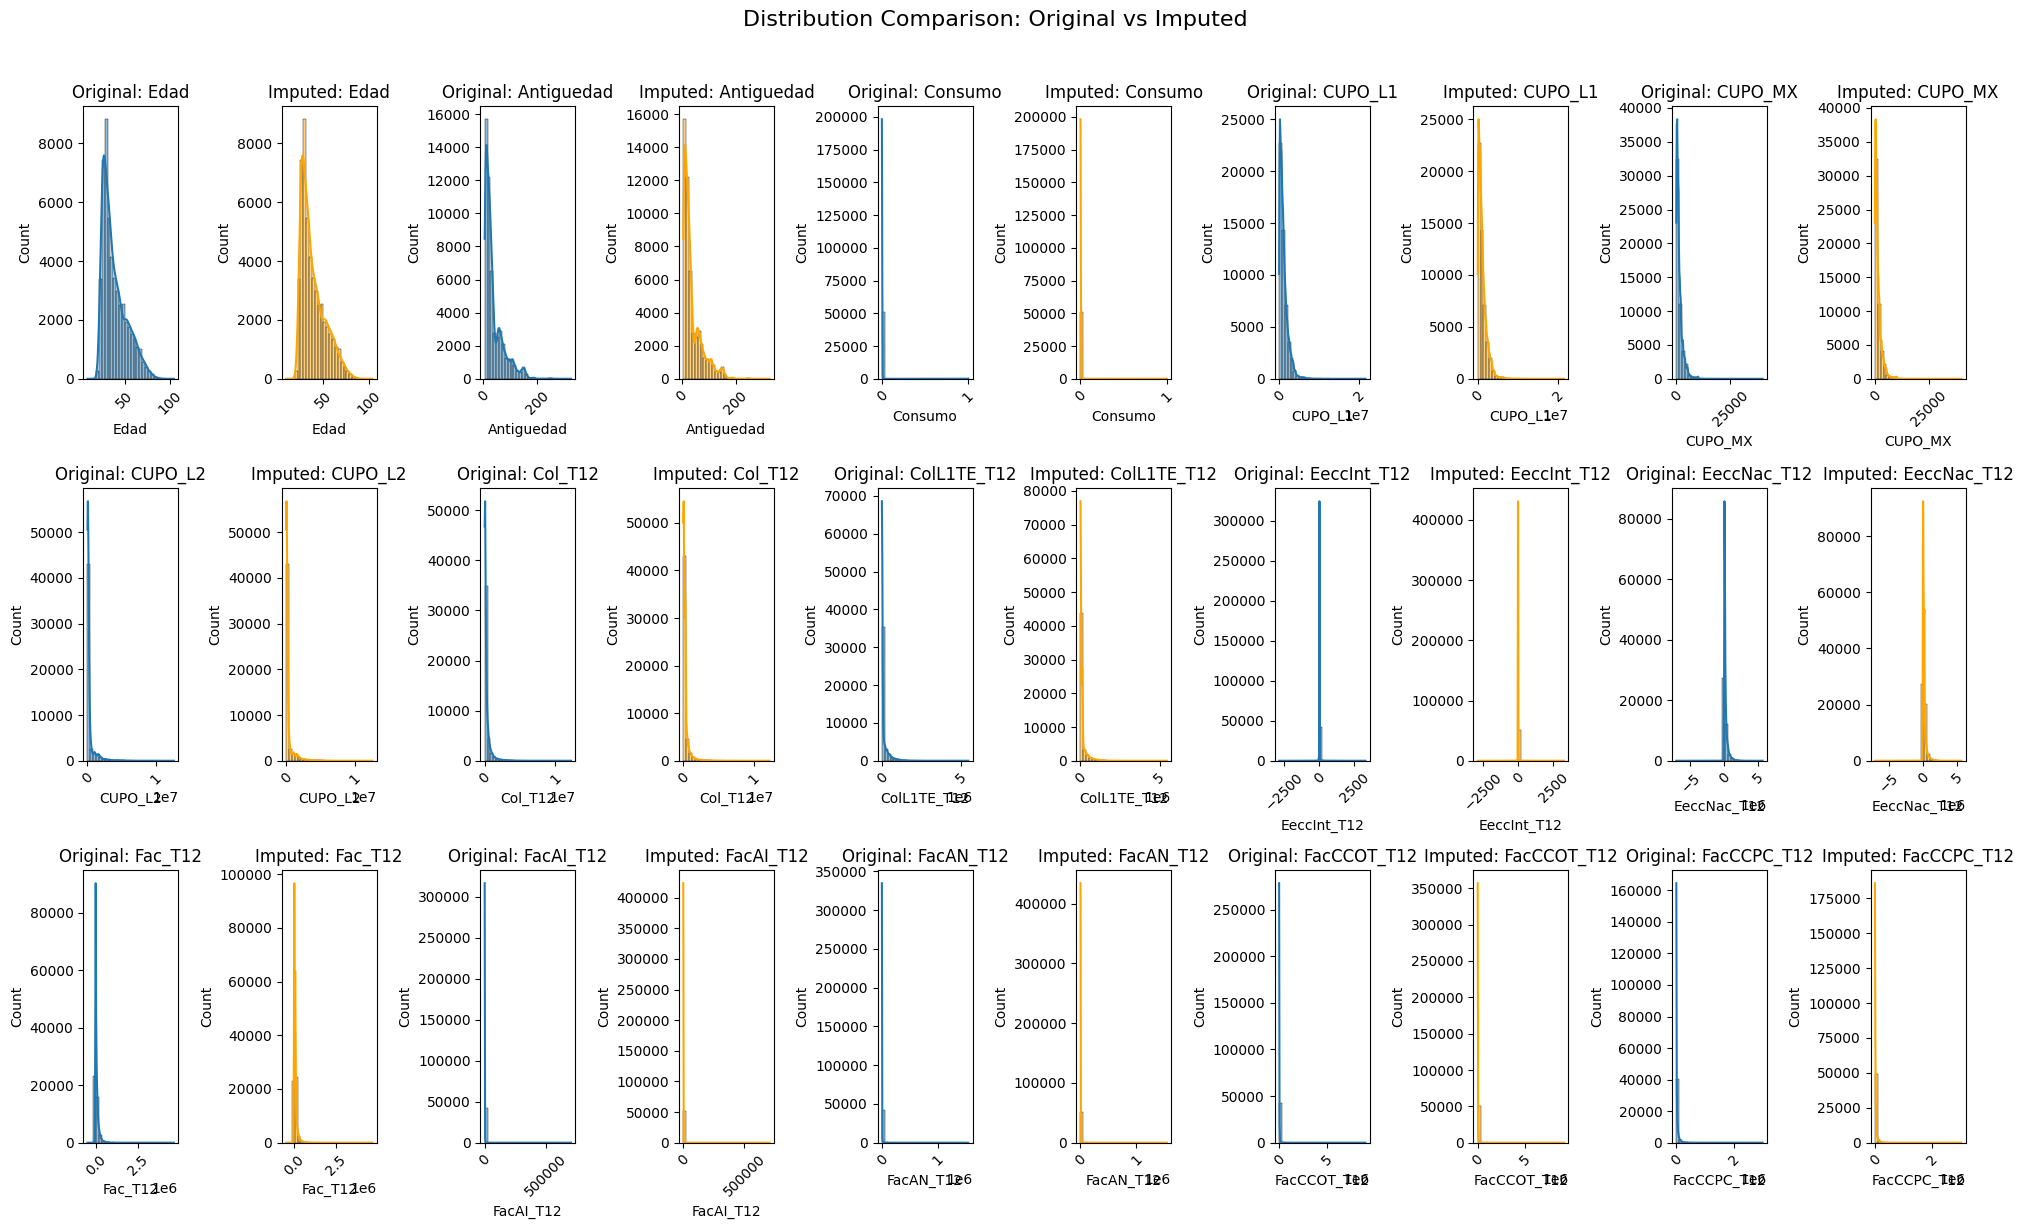


Categorical variables distributions:


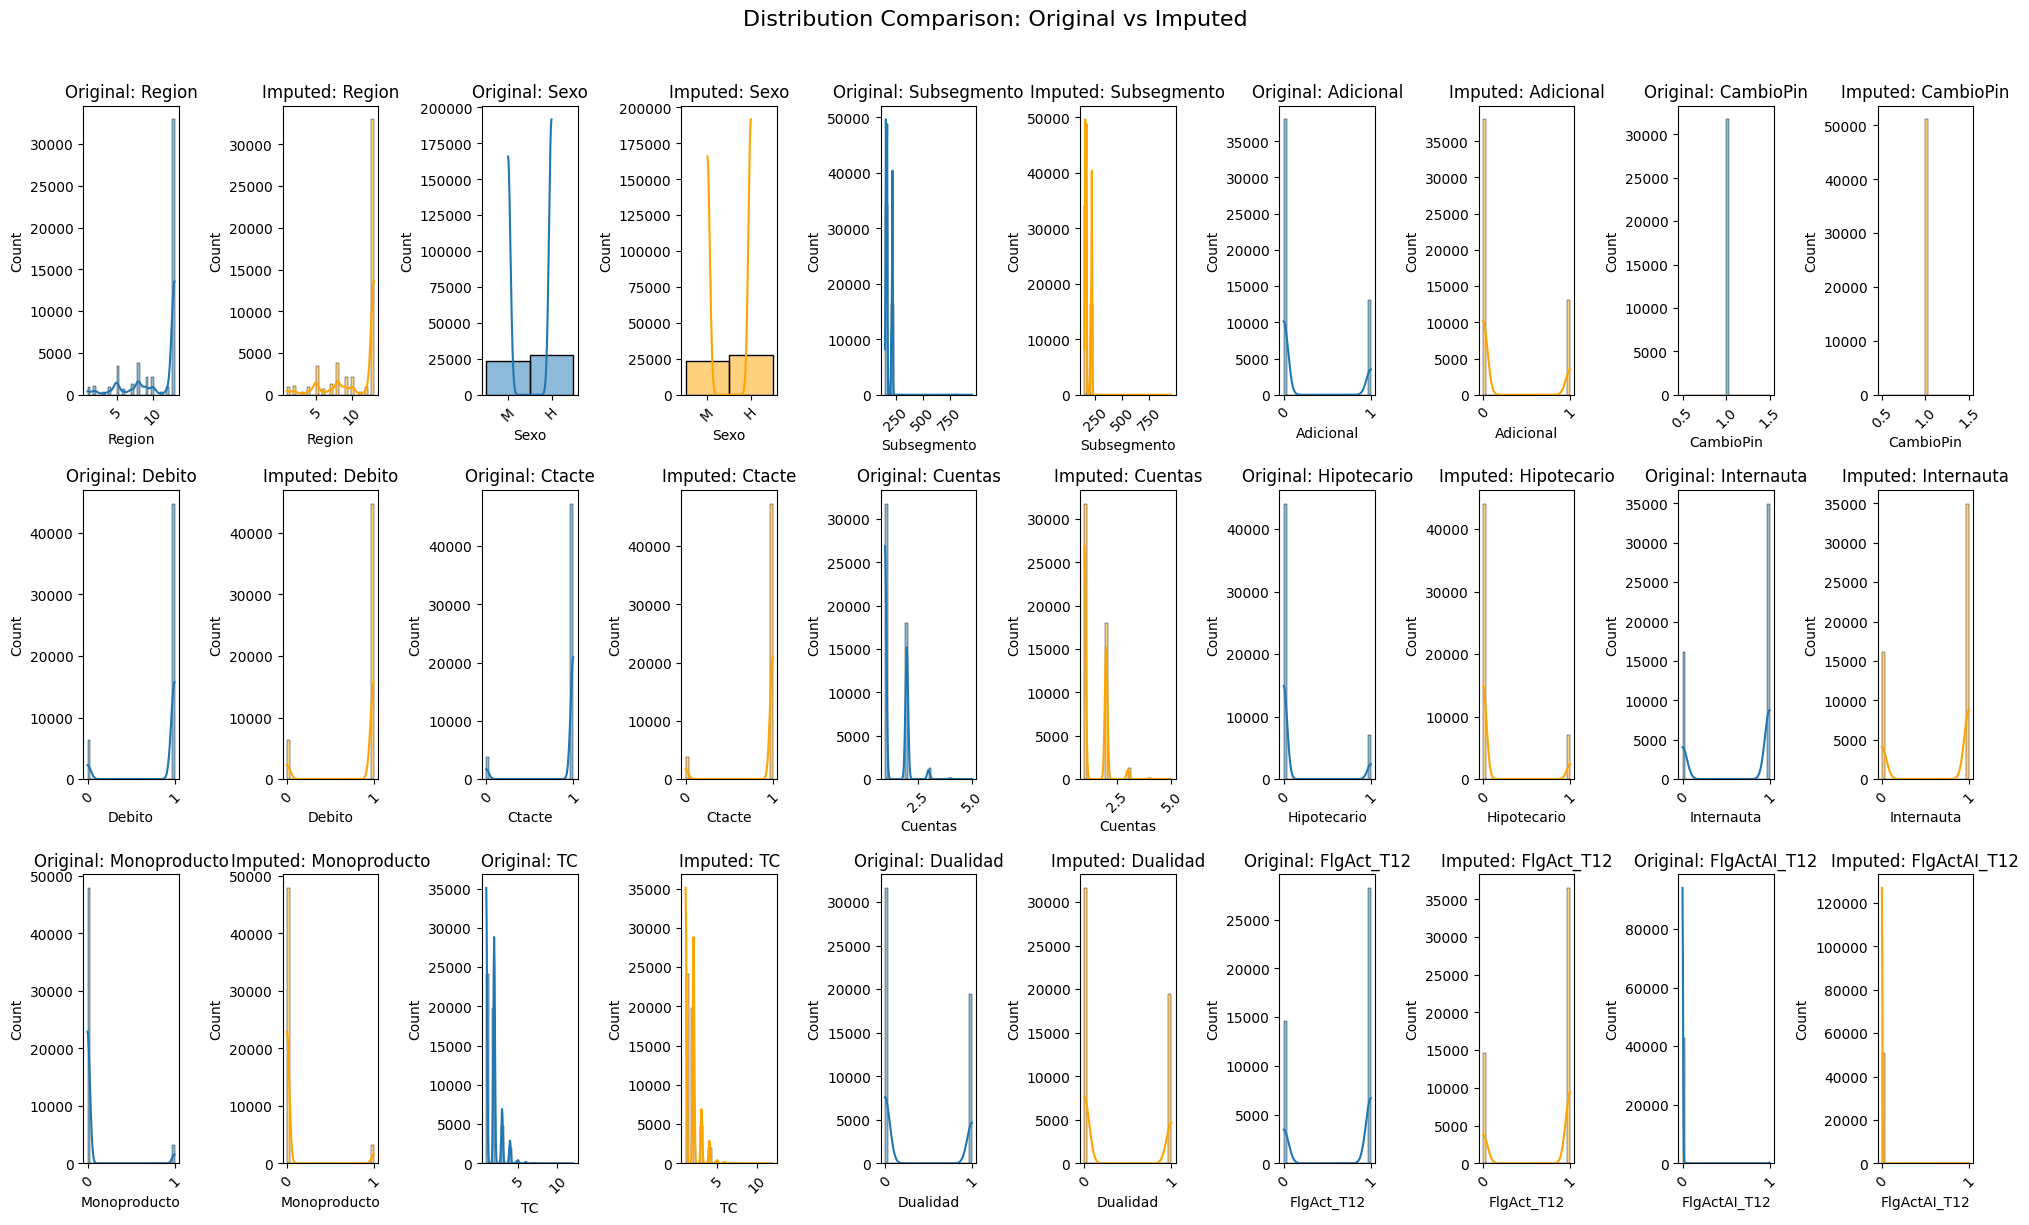

In [22]:

cols_numerics = [
    'Edad', 'Antiguedad', 'Consumo', 'CUPO_L1', 'CUPO_MX', 'CUPO_L2',
    'Col_T12', 'ColL1TE_T12', 'EeccInt_T12', 'EeccNac_T12', 'Fac_T12', 
    'FacAI_T12', 'FacAN_T12', 'FacCCOT_T12', 'FacCCPC_T12', 'FacCI_T12', 
    'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 'FacDebCom_T12', 'FacPAT_T12',
    'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 'TxsAI_T12', 'TxsAN_T12', 
    'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12', 'TxsCN_T12', 'TxsCOL_T12', 
    'TxsDebAtm_T12', 'TxsDebCom_T12', 'TxsPAT_T12', 'UsoL1_T12', 'UsoL2_T12', 
    'UsoLI_T12'
]

cols_categoric = [
    'Region', 'Sexo', 'Subsegmento', 'Adicional', 'CambioPin', 'Debito', 
    'Ctacte', 'Cuentas', 'Hipotecario', 'Internauta', 'Monoproducto', 'TC', 
    'Dualidad', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12', 'FlgActCCOT_T12',
    'FlgActCCPC_T12', 'FlgActCI_T12', 'FlgActCN_T12', 'FlgActCOL_T12', 
    'FlgActPAT_T12'
]

numeric_imputer = SimpleImputer(strategy='mean')

ds_imputed = ds.copy()  
ds_imputed[cols_numerics] = numeric_imputer.fit_transform(ds_imputed[cols_numerics])

categorical_imputer = SimpleImputer(strategy='most_frequent')

ds_imputed[cols_categoric] = categorical_imputer.fit_transform(ds_imputed[cols_categoric])


def compare_distributions(ds_original, ds_imputed, columns, n_columns=5):
    n_rows = int(np.ceil(len(columns) / n_columns))
    
    plt.figure(figsize=(20, 4*n_rows))
    
    for i, column in enumerate(columns, 1):
        plt.subplot(n_rows, n_columns*2, i*2-1)
        sns.histplot(ds_original[column], kde=True, bins=30)
        plt.title(f'Original: {column}')
        plt.xticks(rotation=45)
        
        plt.subplot(n_rows, n_columns*2, i*2)
        sns.histplot(ds_imputed[column], kde=True, bins=30, color='orange')
        plt.title(f'Imputed: {column}')
        plt.xticks(rotation=45)
    
    plt.suptitle('Distribution Comparison: Original vs Imputed', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

print("Numeric variables distributions:")
numeric_cols_display = cols_numerics[:15]
compare_distributions(ds, ds_imputed, numeric_cols_display)

print("\nCategorical variables distributions:")
categorical_cols_display = cols_categoric[:15]
compare_distributions(ds, ds_imputed, categorical_cols_display)

This code ensures comprehensive handling of missing values while maintaining data integrity and providing visual validation of the imputation process.

In [23]:
def calculate_null_percentage(df):
    nulls_per_column = df.isnull().sum()
    null_percentage = (nulls_per_column / len(df)) * 100
    return null_percentage

percentage_before = calculate_null_percentage(ds)
percentage_after = calculate_null_percentage(ds_imputed)

null_comparison = pd.DataFrame({
    'Null_Percentage_Before': percentage_before,
    'Null_Percentage_After': percentage_after,
    'Reduction': percentage_before - percentage_after
})

null_comparison = null_comparison[null_comparison['Null_Percentage_Before'] > 0]

null_comparison = null_comparison.sort_values('Reduction', ascending=False)

print("\nSummary of null values reduction:")
print("-" * 80)
print(null_comparison.round(2))
print("\nGeneral statistics:")
print("-" * 80)
print(f"Average reduction: {null_comparison['Reduction'].mean():.2f}%")
print(f"Maximum reduction: {null_comparison['Reduction'].max():.2f}%")
print(f"Total columns with null values before imputation: {len(null_comparison)}")
print(f"Total percentage of missing data before: {percentage_before.mean():.2f}%")
print(f"Total percentage of missing data after: {percentage_after.mean():.2f}%")


Summary of null values reduction:
--------------------------------------------------------------------------------
                Null_Percentage_Before  Null_Percentage_After  Reduction
0                                                                       
CambioPin                        37.92                   0.00      37.92
EeccInt_T12                      16.14                   0.00      16.14
ColL1TE_T12                      16.14                   0.00      16.14
Col_T12                          16.14                   0.00      16.14
Fac_T12                          16.14                   0.00      16.14
FacAI_T12                        16.14                   0.00      16.14
FacAN_T12                        16.14                   0.00      16.14
EeccNac_T12                      16.14                   0.00      16.14
FacCCOT_T12                      16.14                   0.00      16.14
FacCN_T12                        16.14                   0.00      16.14
FacCI_T1

Calculates percentage of null values in dataset, compares before and after imputation and Tracks reduction in missing values

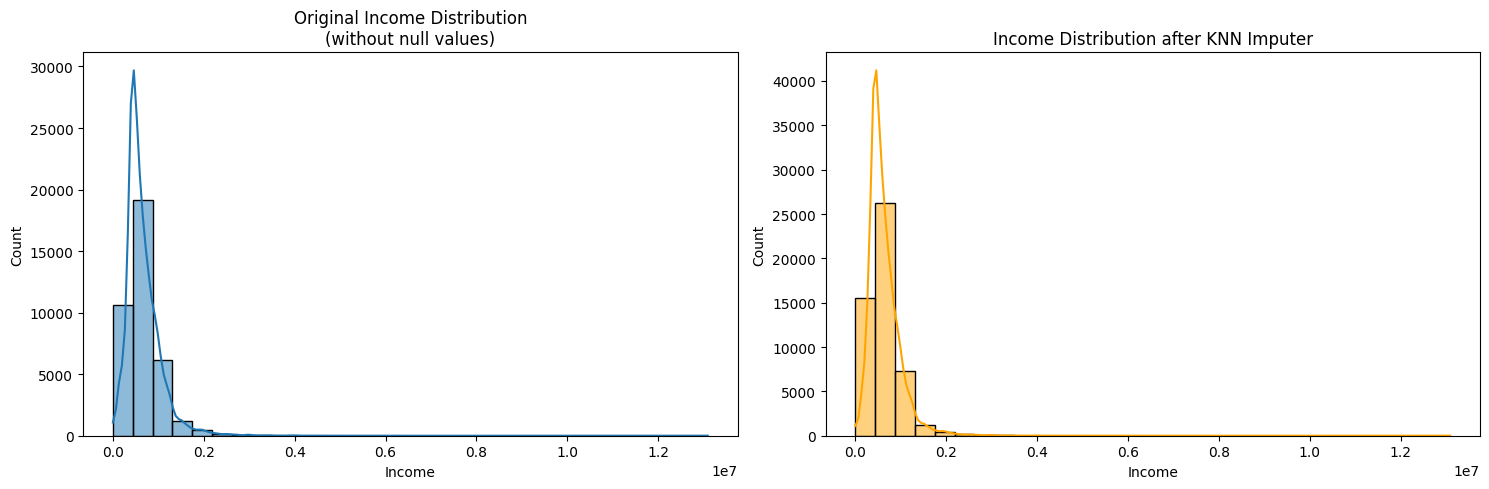


Income variable statistics:
--------------------------------------------------

Before imputation:
count       37759.00
mean       663077.08
std        409279.46
min             1.00
25%        419999.00
50%        567012.00
75%        814903.50
max      13089327.00
Name: Renta, dtype: float64
Null values: 13365 (26.14%)

After imputation:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64
Null values: 0 (0.00%)


In [28]:
variables_for_income = [
    'Renta', 'Edad', 'Consumo', 'CUPO_L1', 'CUPO_MX', 
    'Fac_T12', 'PagoInt_T12', 'PagoNac_T12'
]

df_knn = ds_imputed[variables_for_income].copy()

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_knn),
    columns=df_knn.columns
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(ds['Renta'].dropna(), kde=True, bins=30)
plt.title('Original Income Distribution\n(without null values)')
plt.xlabel('Income')

plt.subplot(1, 2, 2)
sns.histplot(df_knn_imputed['Renta'], kde=True, bins=30, color='orange')
plt.title('Income Distribution after KNN Imputer')
plt.xlabel('Income')

plt.tight_layout()
plt.show()

print("\nIncome variable statistics:")
print("-" * 50)
print("\nBefore imputation:")
print(ds_imputed['Renta'].describe().round(2))
print(f"Null values: {ds_imputed['Renta'].isnull().sum()} ({(ds_imputed['Renta'].isnull().sum()/len(ds)*100):.2f}%)")

print("\nAfter imputation:")
print(df_knn_imputed['Renta'].describe().round(2))
print(f"Null values: {df_knn_imputed['Renta'].isnull().sum()} ({(df_knn_imputed['Renta'].isnull().sum()/len(df_knn_imputed)*100):.2f}%)")

ds_imputed['Renta'] = df_knn_imputed['Renta']

This code implements a sophisticated imputation strategy specifically for the income variable, using related features to ensure realistic value estimation.

In [30]:
for column in cols_numerics:
    ds_imputed[column] = ds_imputed[column].round().astype('int64')

print("Data types after conversion:")
print("-" * 50)
for column in cols_numerics:
    print(f"{column}: {ds_imputed[column].dtype}")

print("\nFirst rows of some numeric columns:")
print("-" * 50)
print(ds_imputed[cols_numerics[:5]].head())

print("\nDecimal values verification:")
print("-" * 50)
for column in cols_numerics:
    if (ds_imputed[column] % 1 != 0).any():
        print(f"Warning! {column} still has decimals")

Data types after conversion:
--------------------------------------------------
Edad: int64
Antiguedad: int64
Consumo: int64
CUPO_L1: int64
CUPO_MX: int64
CUPO_L2: int64
Col_T12: int64
ColL1TE_T12: int64
EeccInt_T12: int64
EeccNac_T12: int64
Fac_T12: int64
FacAI_T12: int64
FacAN_T12: int64
FacCCOT_T12: int64
FacCCPC_T12: int64
FacCI_T12: int64
FacCN_T12: int64
FacCOL_T12: int64
FacDebAtm_T12: int64
FacDebCom_T12: int64
FacPAT_T12: int64
PagoInt_T12: int64
PagoNac_T12: int64
Txs_T12: int64
TxsAI_T12: int64
TxsAN_T12: int64
TxsCCOT_T12: int64
TxsCCPC_T12: int64
TxsCI_T12: int64
TxsCN_T12: int64
TxsCOL_T12: int64
TxsDebAtm_T12: int64
TxsDebCom_T12: int64
TxsPAT_T12: int64
UsoL1_T12: int64
UsoL2_T12: int64
UsoLI_T12: int64

First rows of some numeric columns:
--------------------------------------------------
0  Edad  Antiguedad  Consumo  CUPO_L1  CUPO_MX
0    43         130        0   798000     1210
1    46          69        0   750000     1000
2    45          24        0  1350000     

This code ensures all numeric data is properly converted to integers and verifies the conversion's success.

In [33]:
z_scores = stats.zscore(ds_imputed['Renta'])

outliers = np.abs(z_scores) > 3
print(f"Number of outliers in Income: {outliers.sum()}")

variables_of_interest = ['Renta', 'Edad', 'Consumo']

for variable in variables_of_interest:
    z_scores = stats.zscore(ds_imputed[variable])
    outliers = np.abs(z_scores) > 3
    print(f"\nAnalysis of {variable}:")
    print(f"Total outliers: {outliers.sum()}")
    print(f"Percentage of outliers: {(outliers.sum()/len(ds_imputed)*100):.2f}%")

Number of outliers in Income: 746

Analysis of Renta:
Total outliers: 746
Percentage of outliers: 1.46%

Analysis of Edad:
Total outliers: 289
Percentage of outliers: 0.57%

Analysis of Consumo:
Total outliers: 46
Percentage of outliers: 0.09%


This code implements a standard statistical approach to identify outliers in key numerical variables.


Column: Edad
Lower limit: 1.00
Upper limit: 73.00
Outliers found: 778
Percentage of outliers: 1.52%


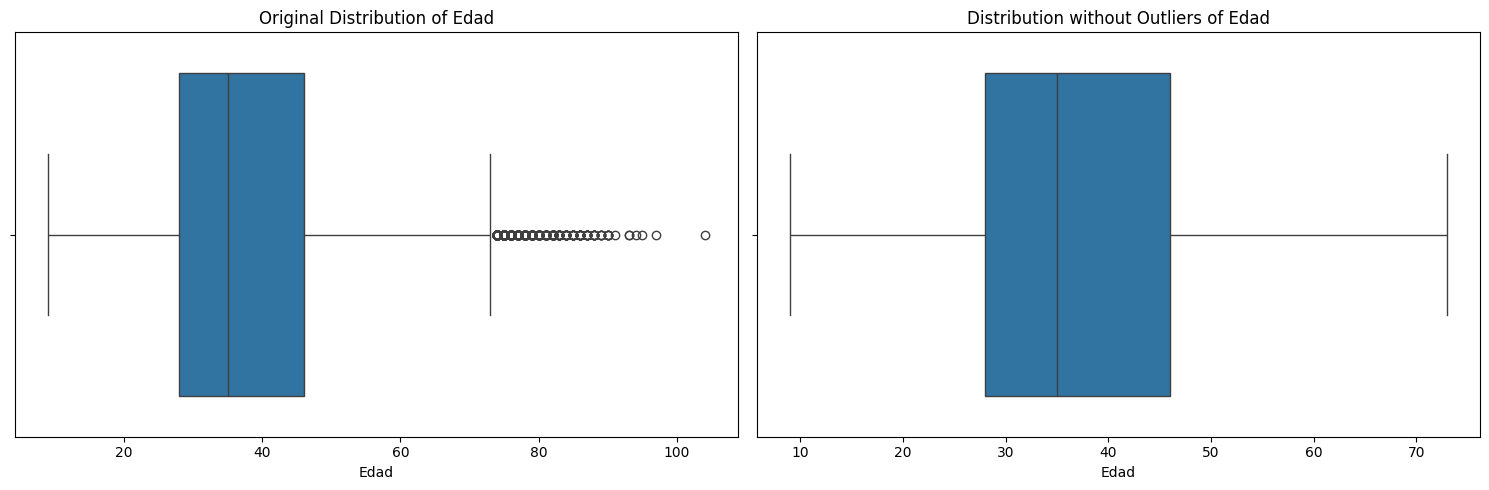


Column: Antiguedad
Lower limit: -46.00
Upper limit: 114.00
Outliers found: 2670
Percentage of outliers: 5.22%


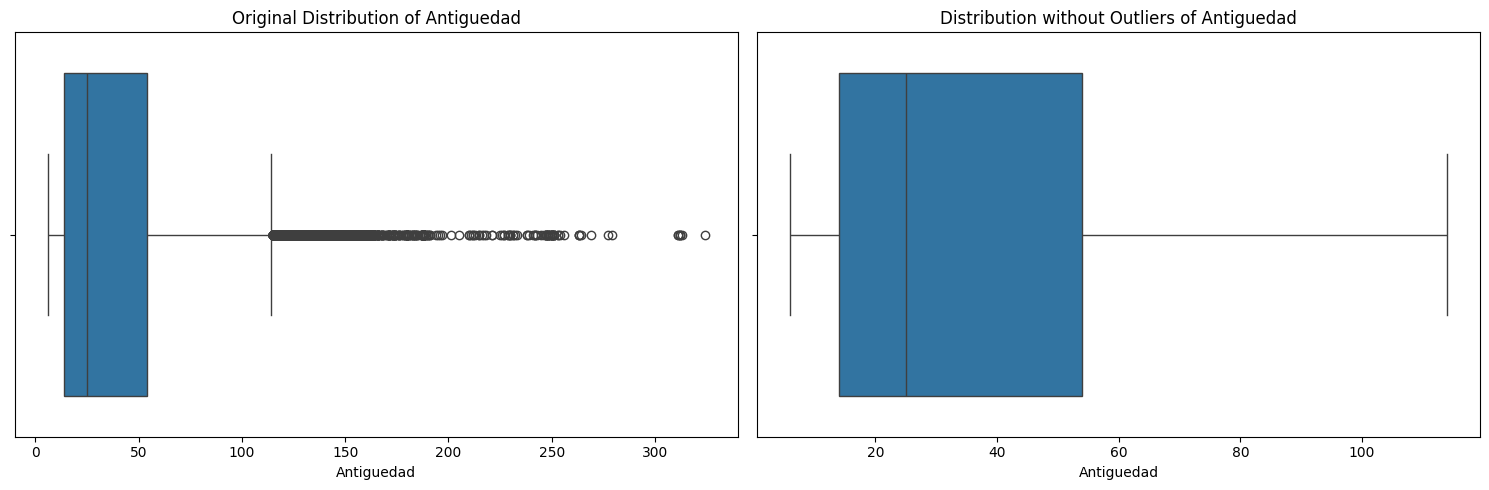


Column: Consumo
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 46
Percentage of outliers: 0.09%


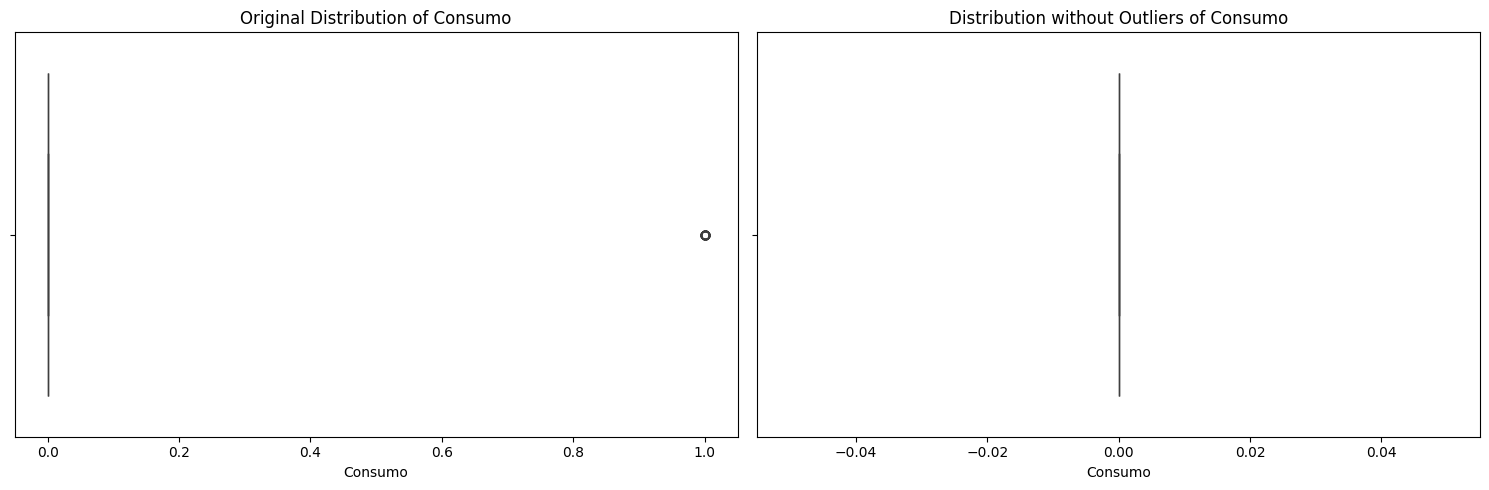


Column: CUPO_L1
Lower limit: -1290500.00
Upper limit: 3217500.00
Outliers found: 2448
Percentage of outliers: 4.79%


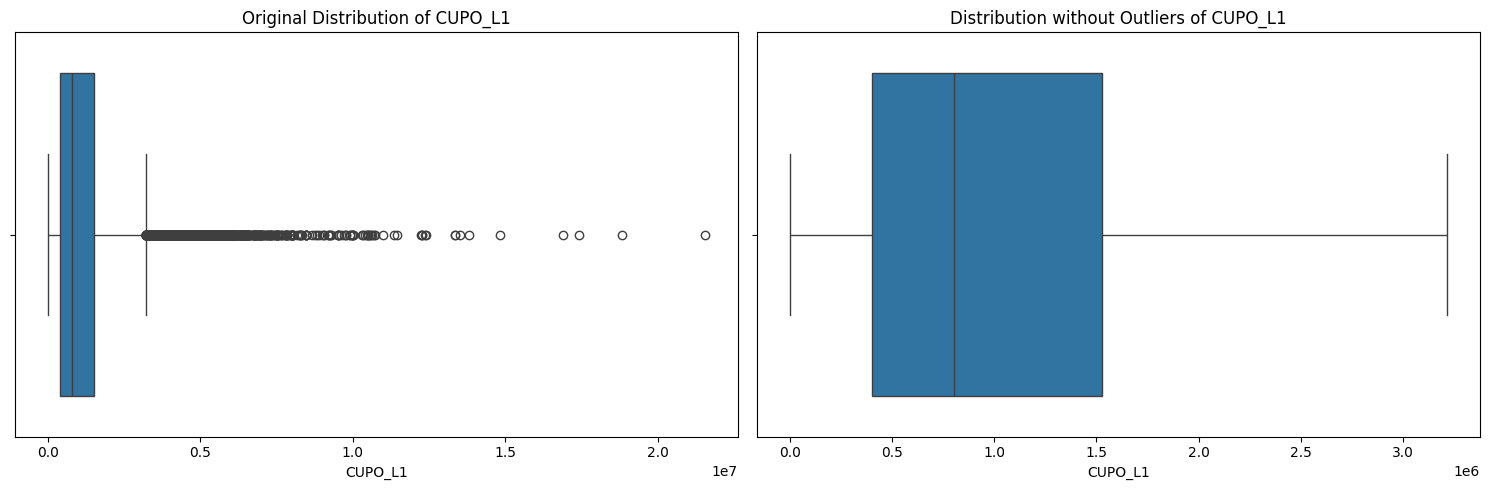


Column: CUPO_MX
Lower limit: -2100.00
Upper limit: 4300.00
Outliers found: 2756
Percentage of outliers: 5.39%


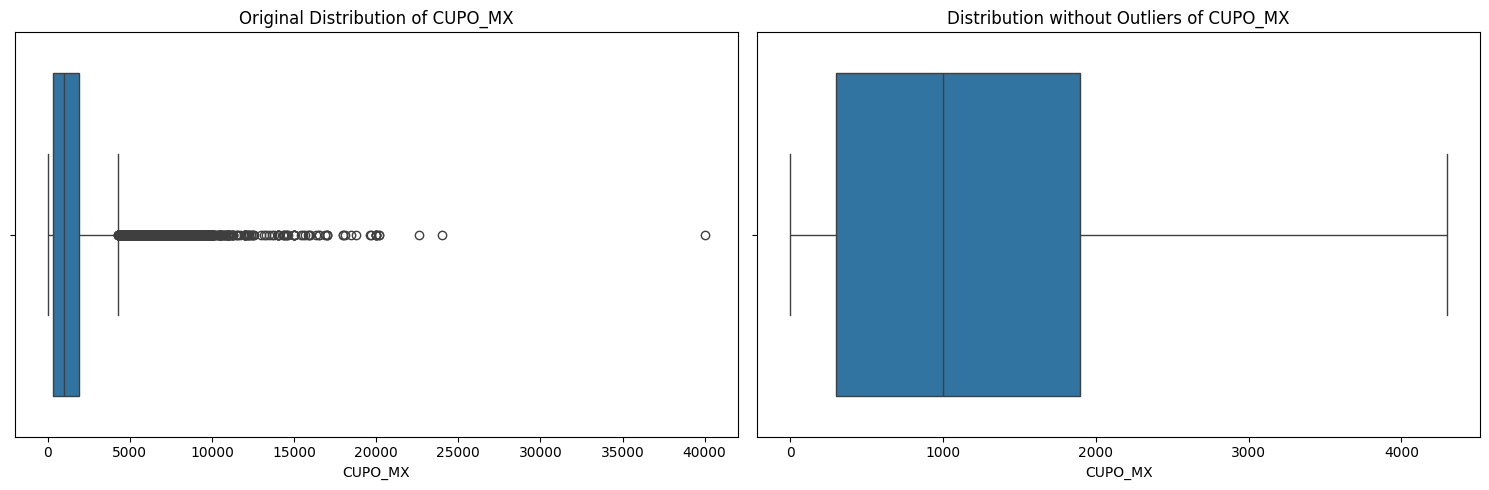

[12/06/24 13:43:00] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=696253;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=786182;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-351543.875'                
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: CUPO_L2
Lower limit: -351543.88
Upper limit: 588573.12
Outliers found: 6617
Percentage of outliers: 12.94%


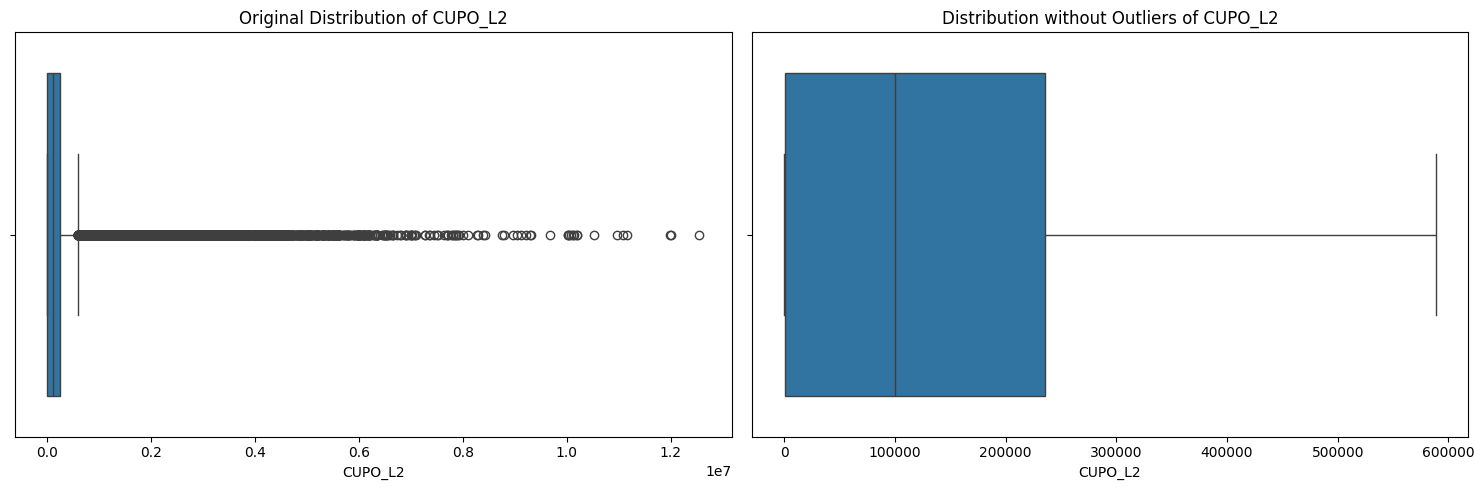

                    WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=54094;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=757623;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-336919.5'                  
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: Col_T12
Lower limit: -336919.50
Upper limit: 649484.50
Outliers found: 4699
Percentage of outliers: 9.19%


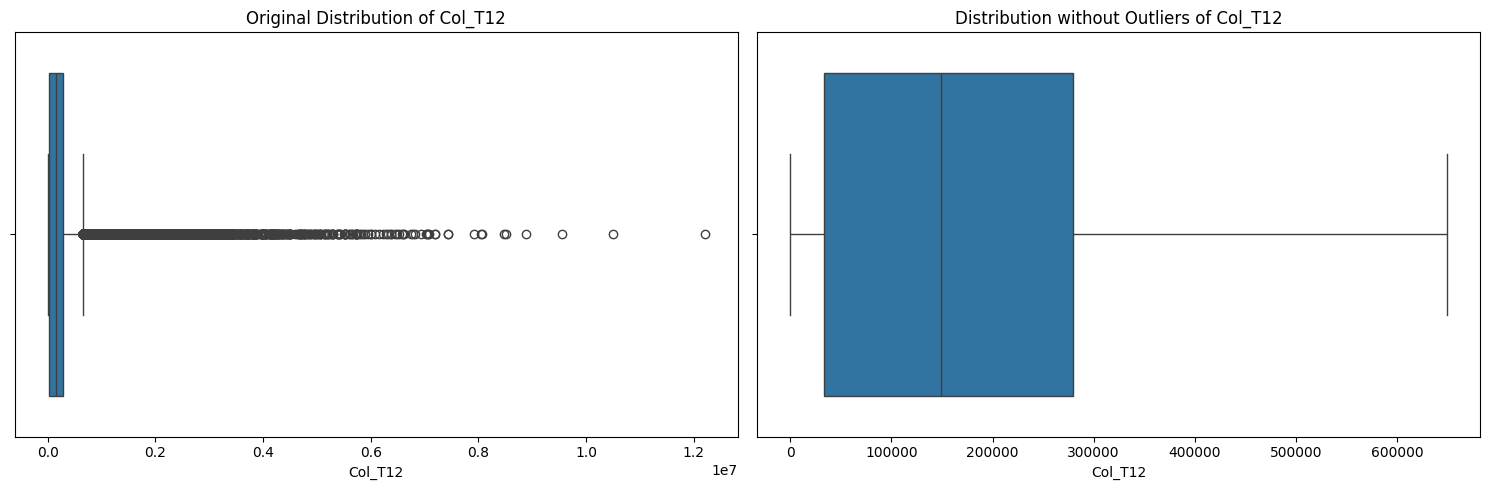


Column: ColL1TE_T12
Lower limit: -162054.00
Upper limit: 270090.00
Outliers found: 5681
Percentage of outliers: 11.11%


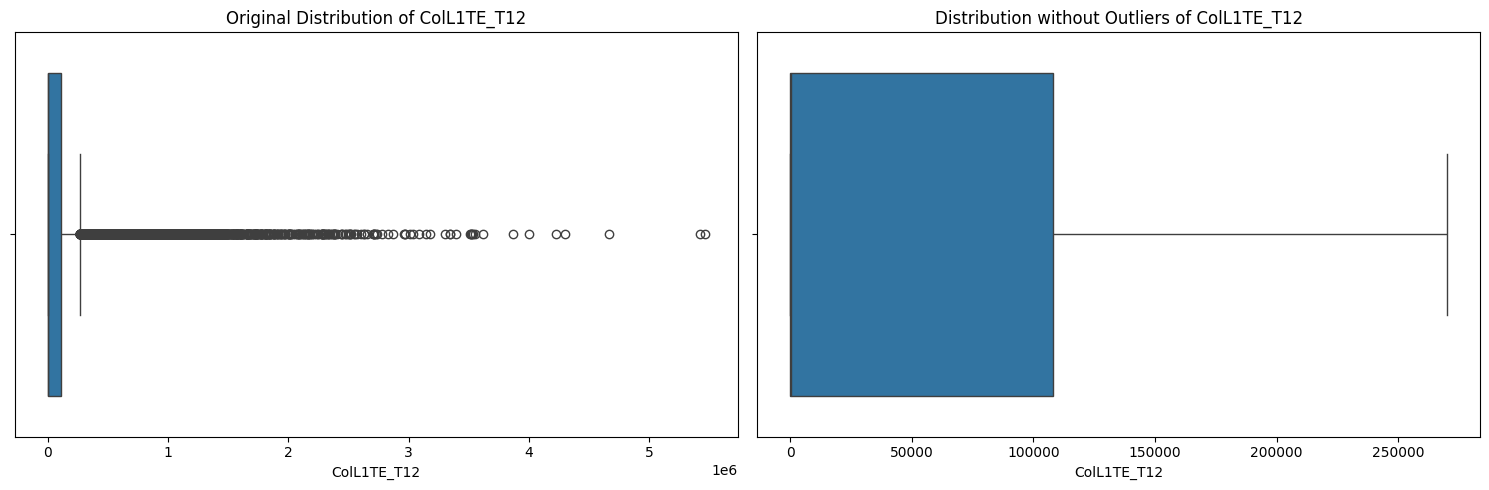


Column: EeccInt_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 10511
Percentage of outliers: 20.56%


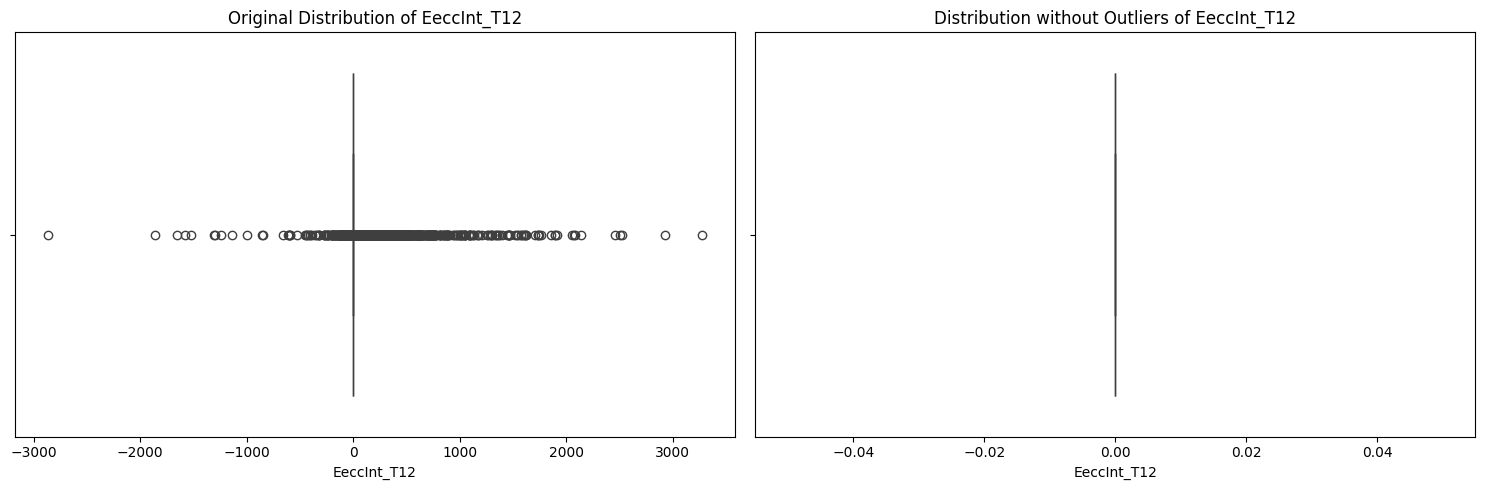

[12/06/24 13:43:01] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=227595;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=382116;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-211047.5'                  
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: EeccNac_T12
Lower limit: -211047.50
Upper limit: 407892.50
Outliers found: 5446
Percentage of outliers: 10.65%


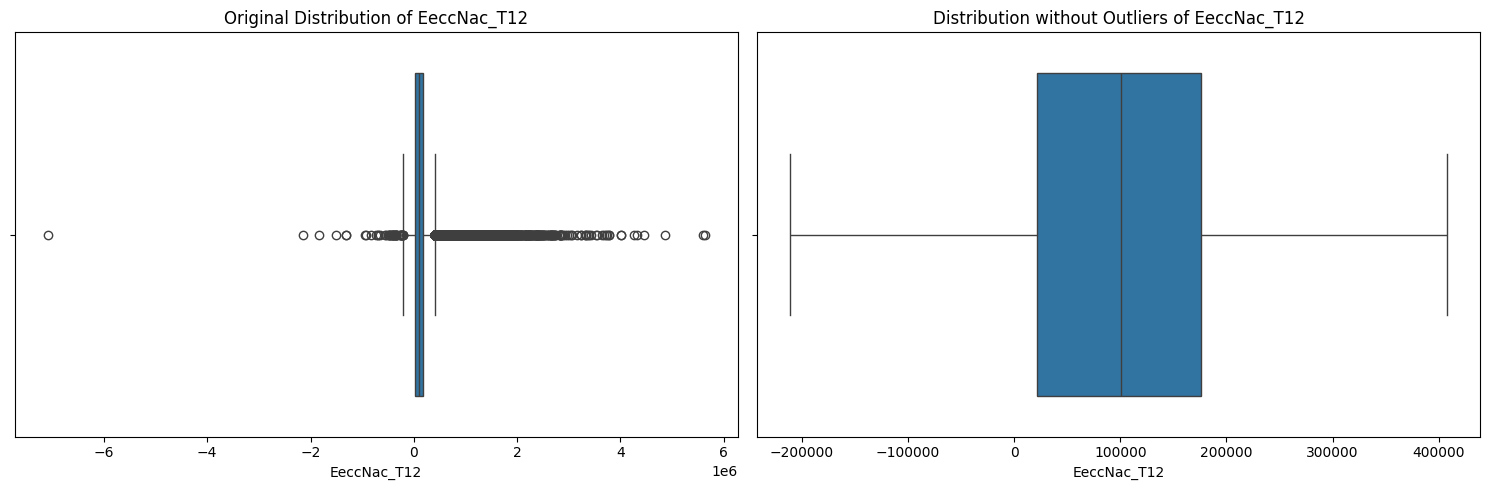


Column: Fac_T12
Lower limit: -102960.00
Upper limit: 171600.00
Outliers found: 4690
Percentage of outliers: 9.17%


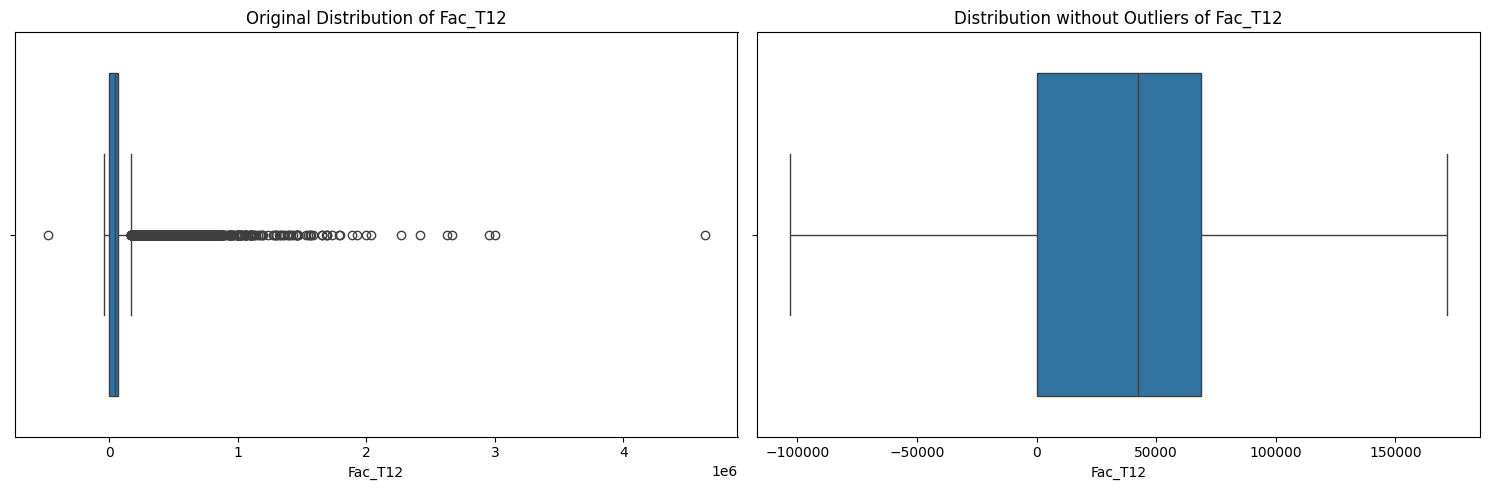


Column: FacAI_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 8361
Percentage of outliers: 16.35%


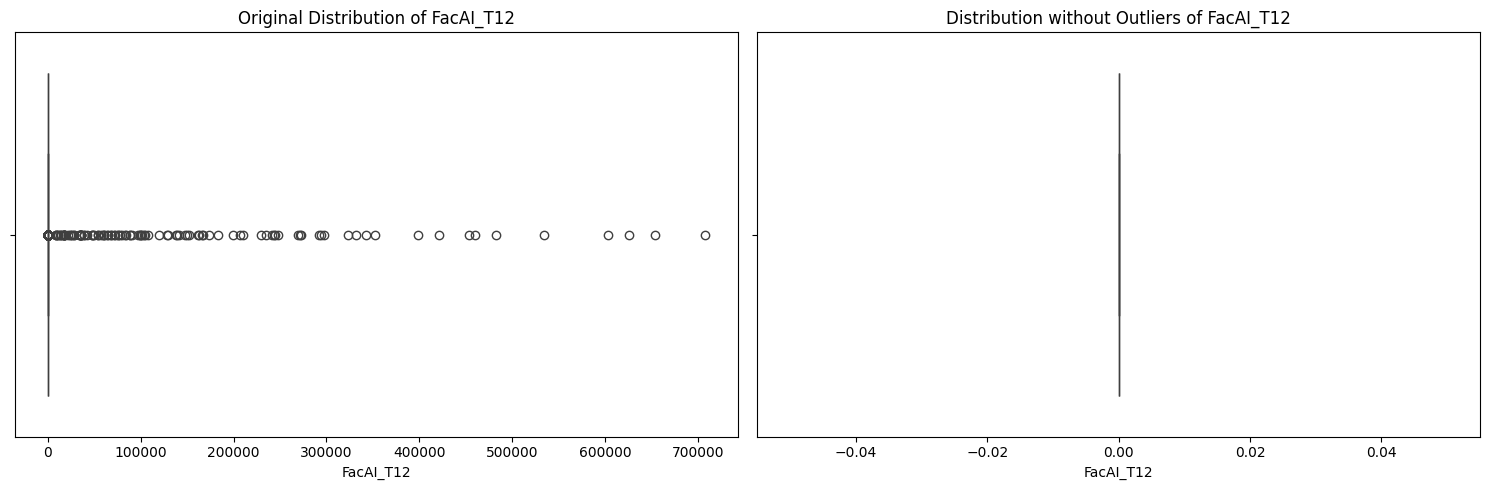


Column: FacAN_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 9194
Percentage of outliers: 17.98%


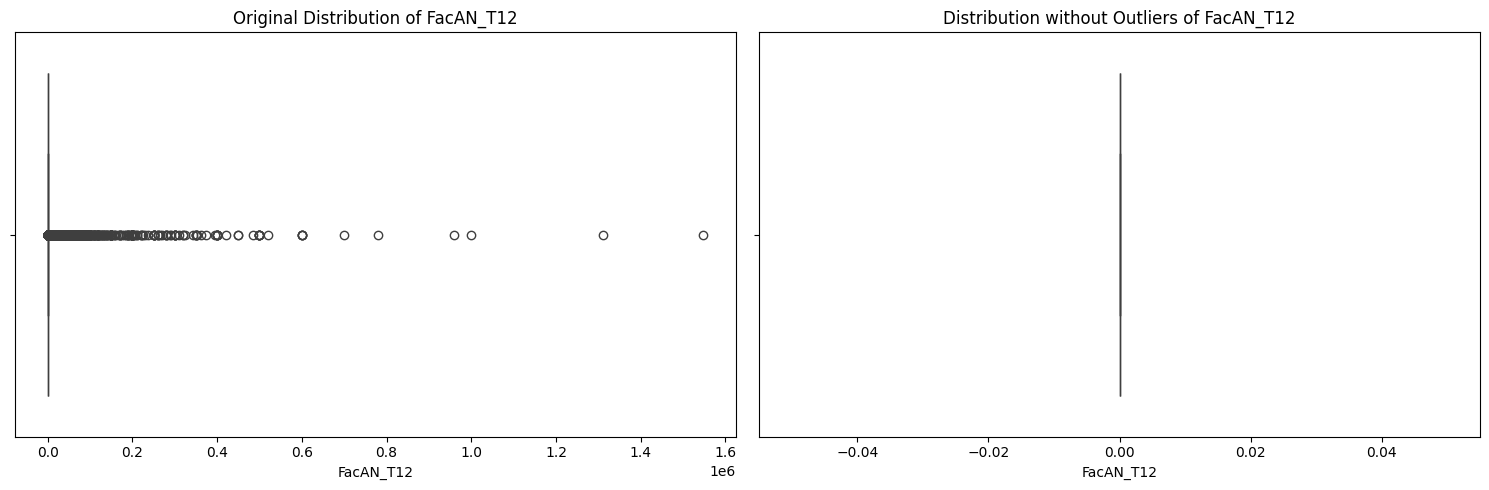


Column: FacCCOT_T12
Lower limit: -7485.00
Upper limit: 12475.00
Outliers found: 12325
Percentage of outliers: 24.11%


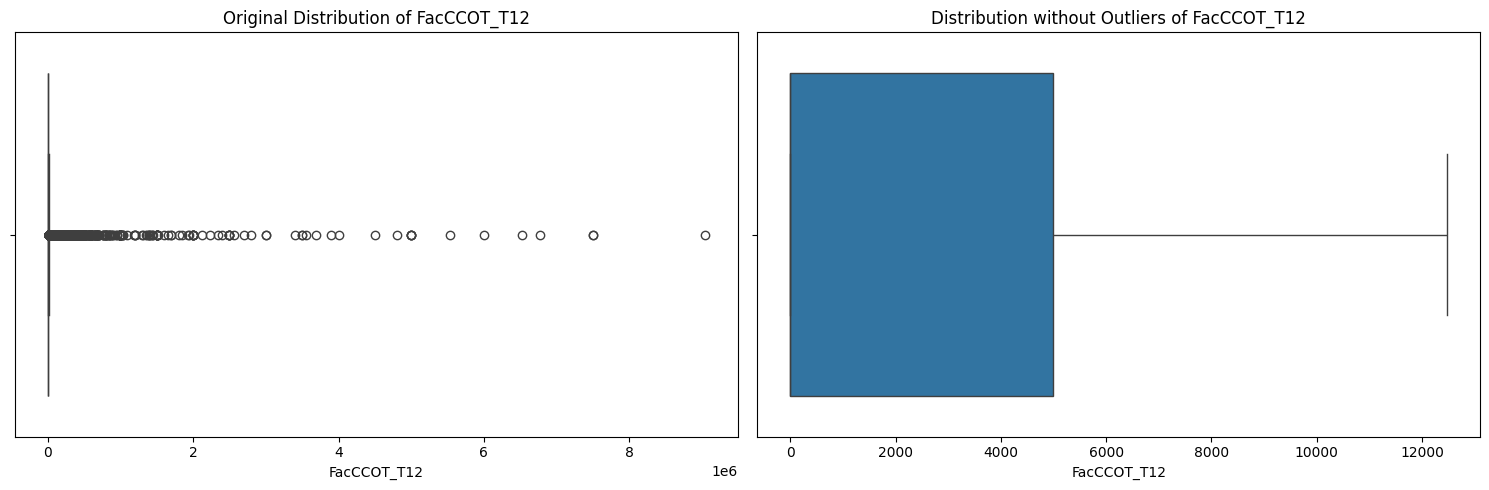

[12/06/24 13:43:03] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=191810;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=118211;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-29251.5'                   
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: FacCCPC_T12
Lower limit: -29251.50
Upper limit: 48752.50
Outliers found: 5004
Percentage of outliers: 9.79%


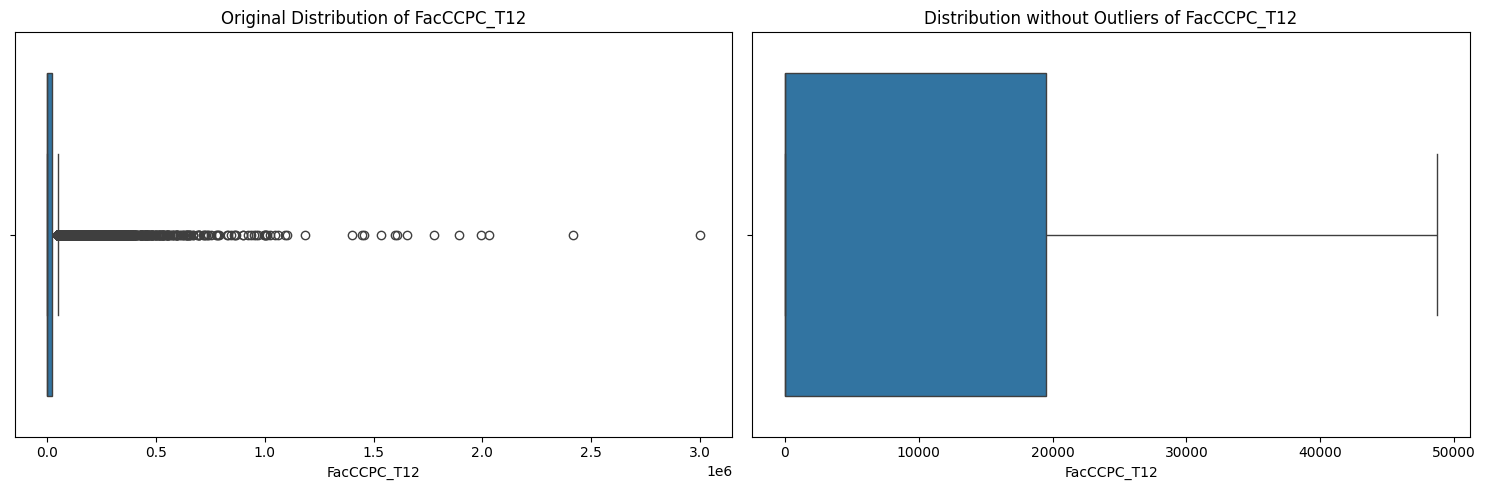


Column: FacCI_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 9678
Percentage of outliers: 18.93%


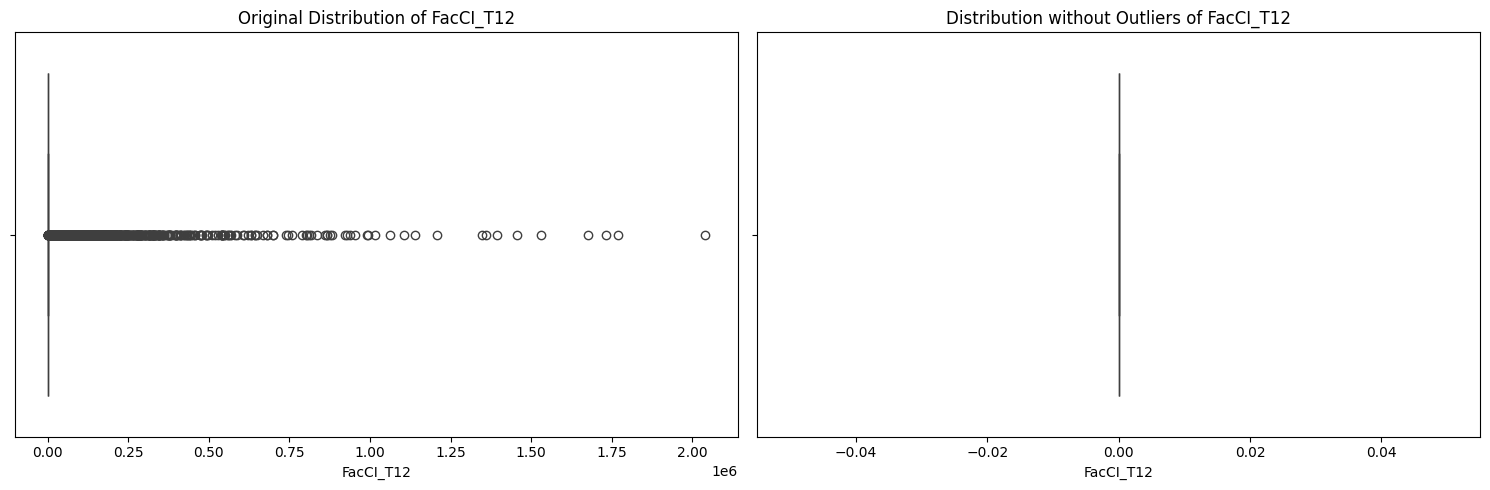

[12/06/24 13:43:04] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=88608;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=79857;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-85306.5'                   
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: FacCN_T12
Lower limit: -85306.50
Upper limit: 142177.50
Outliers found: 5085
Percentage of outliers: 9.95%


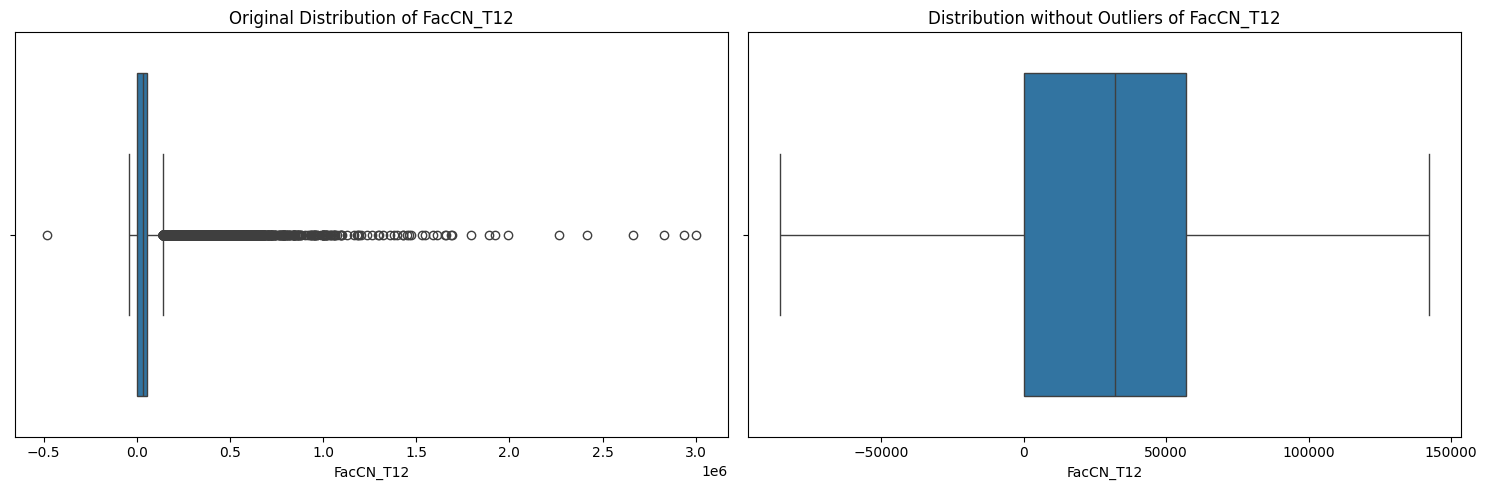


Column: FacCOL_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 8387
Percentage of outliers: 16.41%


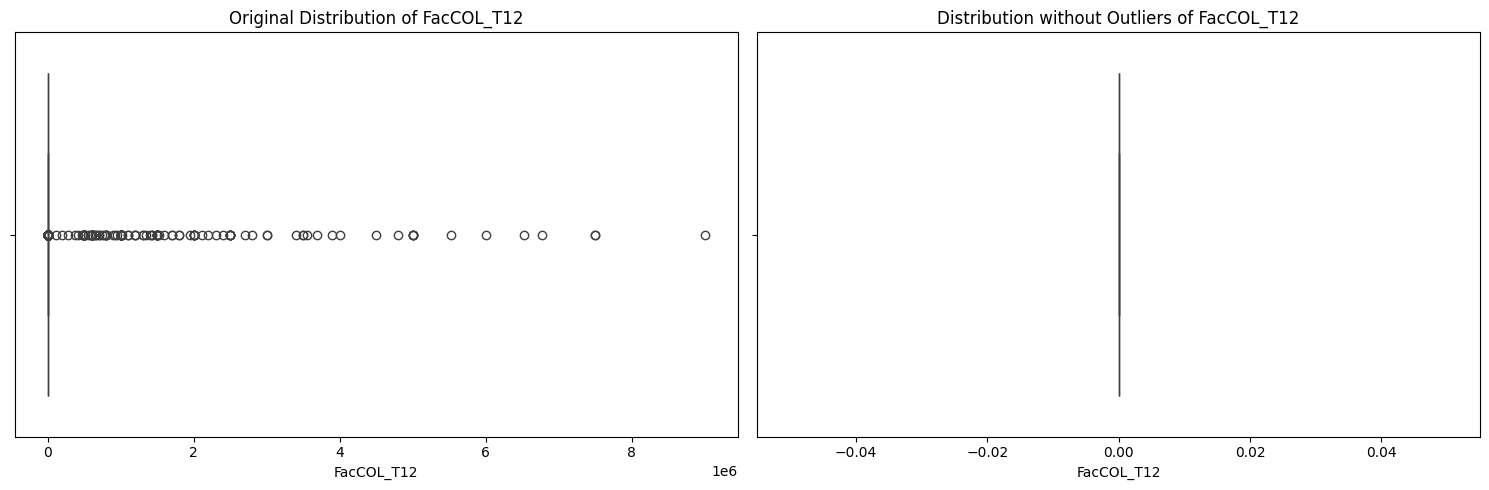


Column: FacDebAtm_T12
Lower limit: -376500.00
Upper limit: 627500.00
Outliers found: 4334
Percentage of outliers: 8.48%


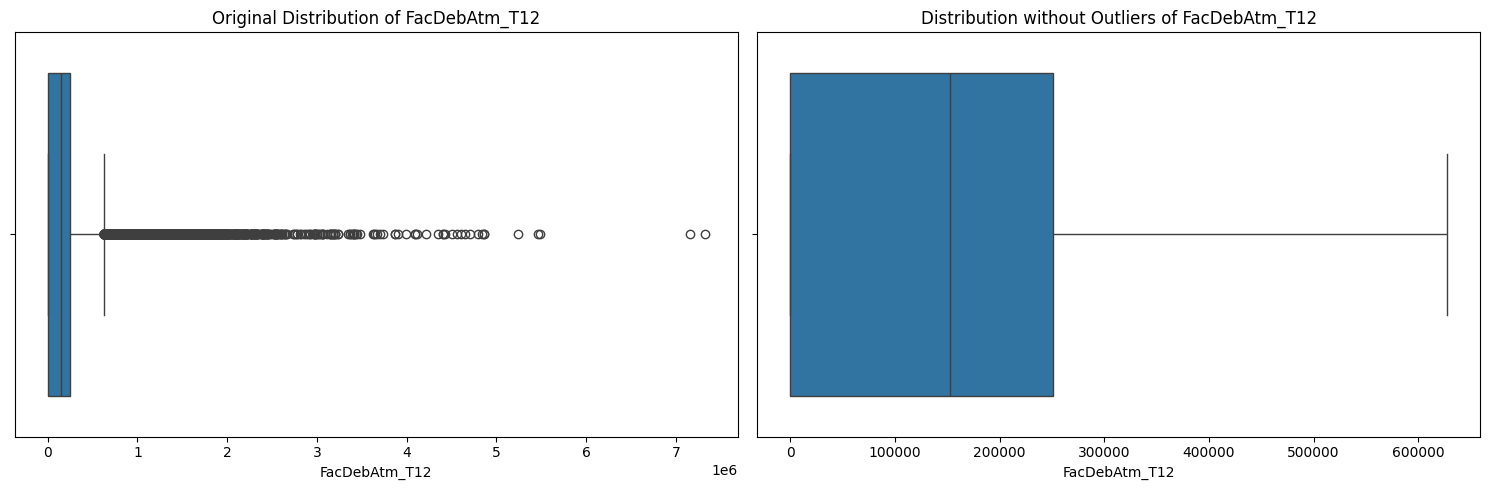

[12/06/24 13:43:05] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=743752;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=484932;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-91252.5'                   
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: FacDebCom_T12
Lower limit: -91252.50
Upper limit: 152087.50
Outliers found: 5619
Percentage of outliers: 10.99%


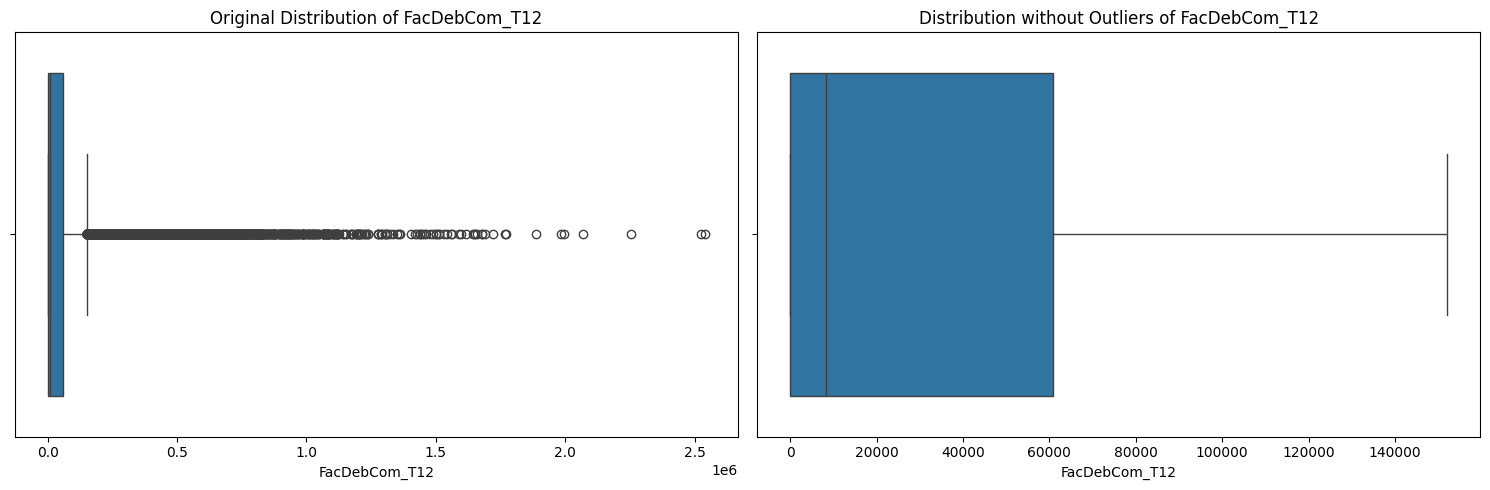

                    WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=272974;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=953987;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-6442.5' has                
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: FacPAT_T12
Lower limit: -6442.50
Upper limit: 10737.50
Outliers found: 3727
Percentage of outliers: 7.29%


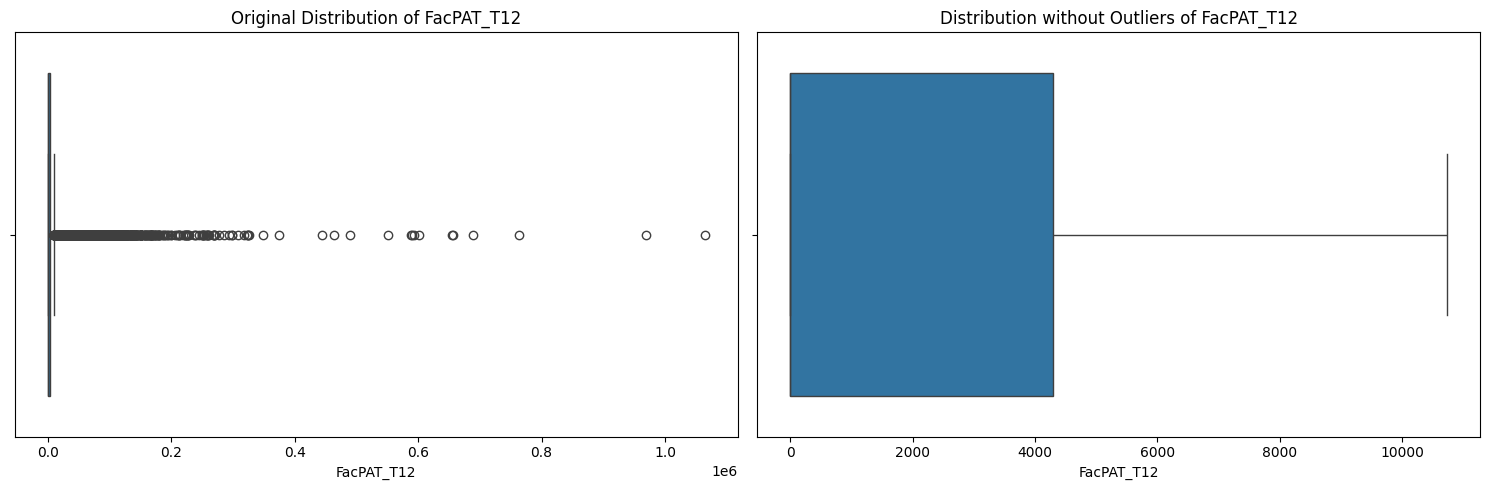


Column: PagoInt_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 8525
Percentage of outliers: 16.68%


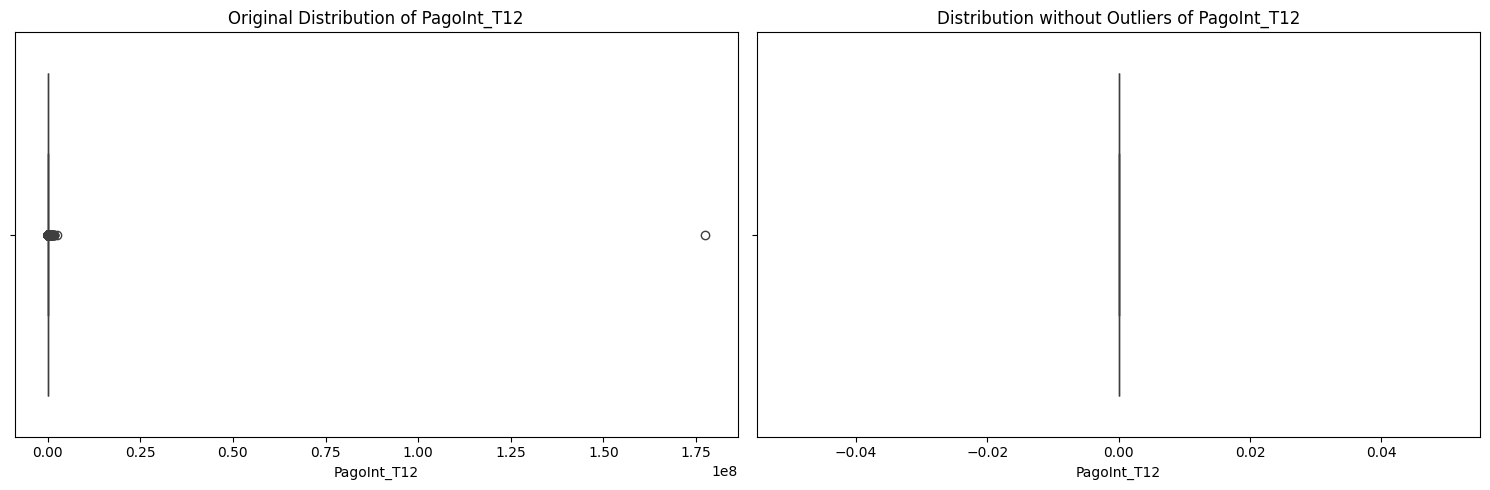


Column: PagoNac_T12
Lower limit: -101355.00
Upper limit: 176925.00
Outliers found: 4461
Percentage of outliers: 8.73%


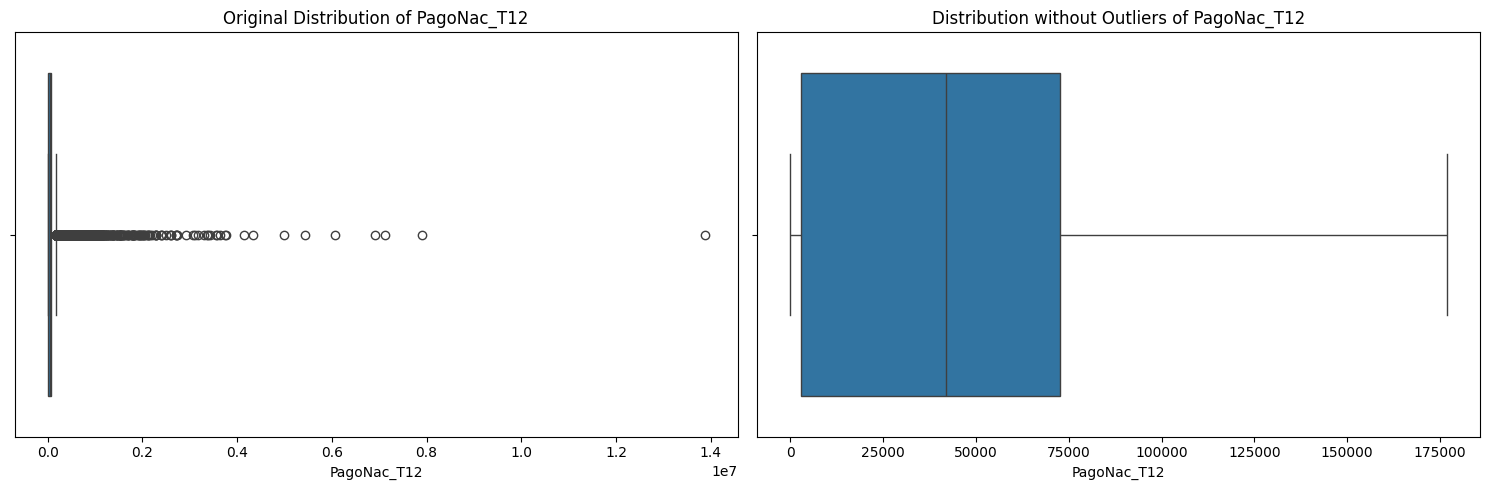

[12/06/24 13:43:07] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=267957;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=351315;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-4.5' has                   
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: Txs_T12
Lower limit: -4.50
Upper limit: 7.50
Outliers found: 3678
Percentage of outliers: 7.19%


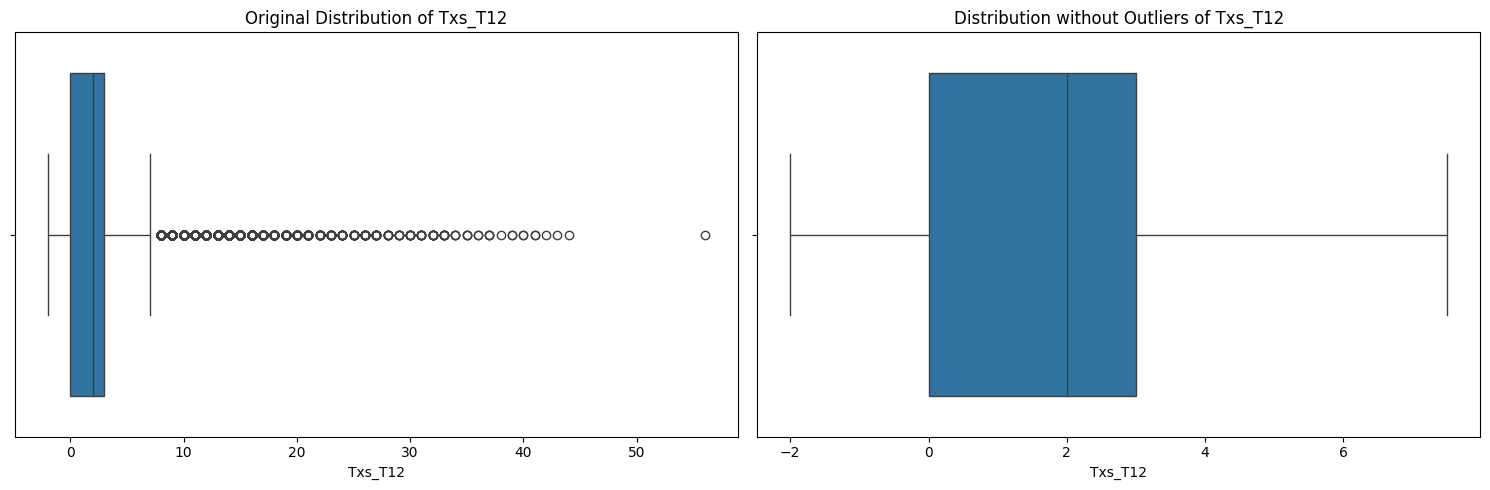


Column: TxsAI_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 110
Percentage of outliers: 0.22%


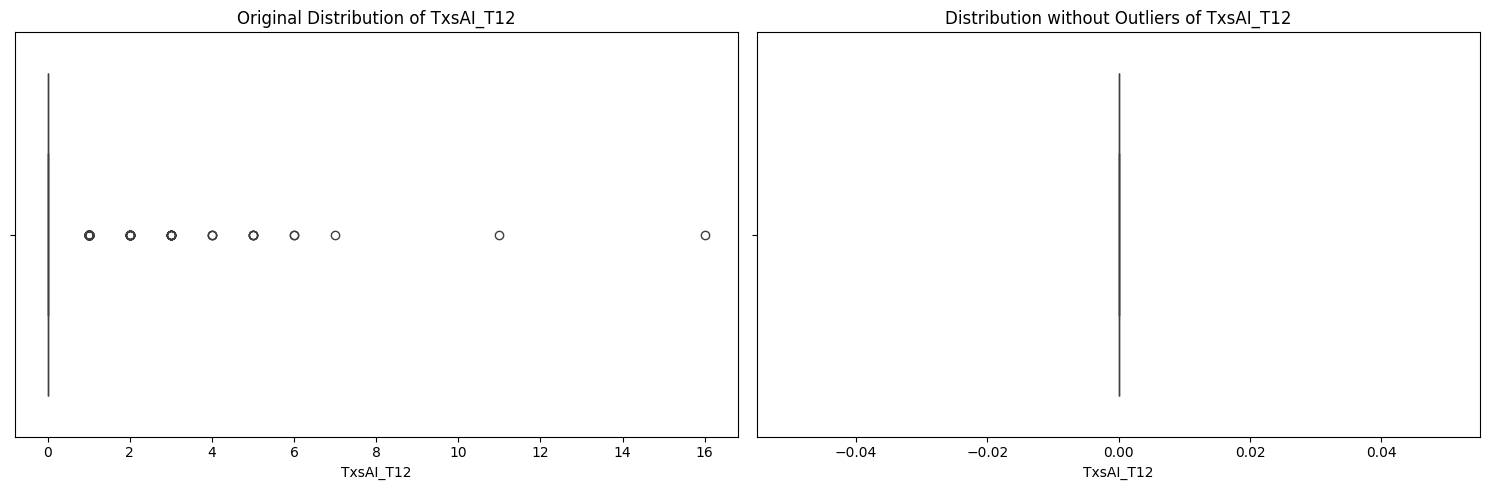


Column: TxsAN_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 943
Percentage of outliers: 1.84%


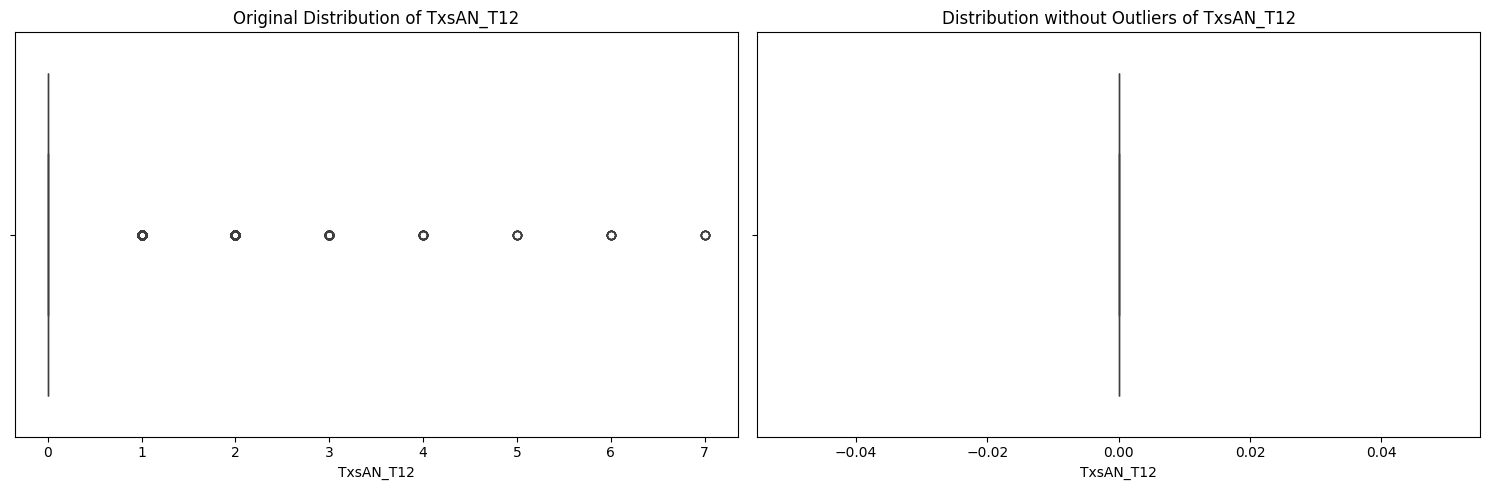


Column: TxsCCOT_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 4616
Percentage of outliers: 9.03%


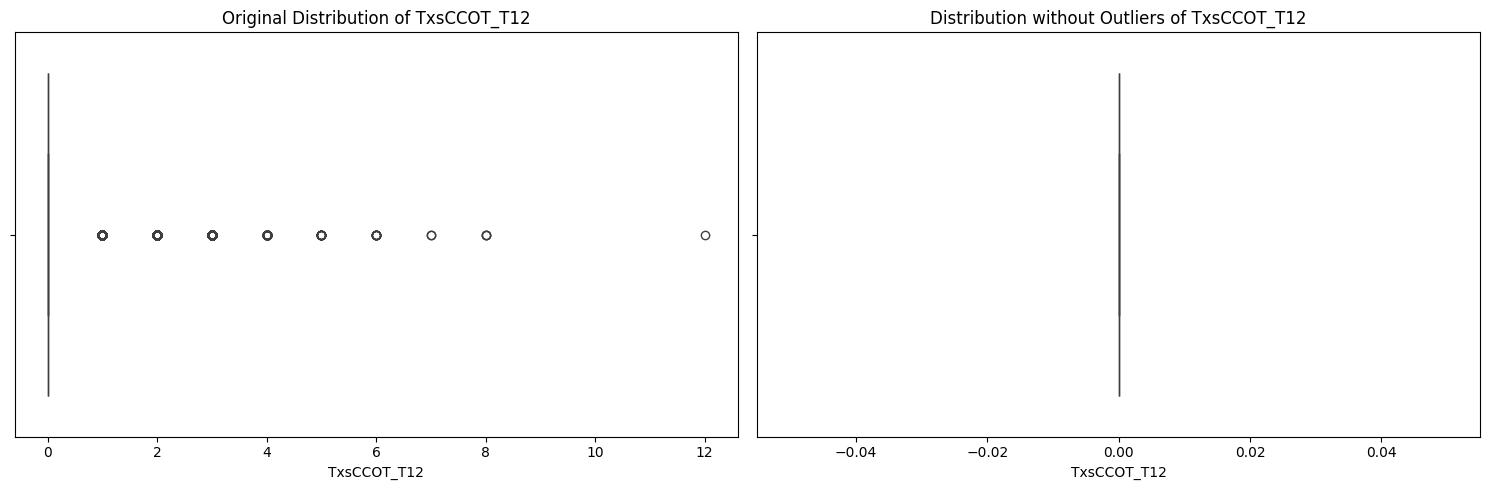

[12/06/24 13:43:08] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=57340;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=612899;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-1.5' has                   
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: TxsCCPC_T12
Lower limit: -1.50
Upper limit: 2.50
Outliers found: 2577
Percentage of outliers: 5.04%


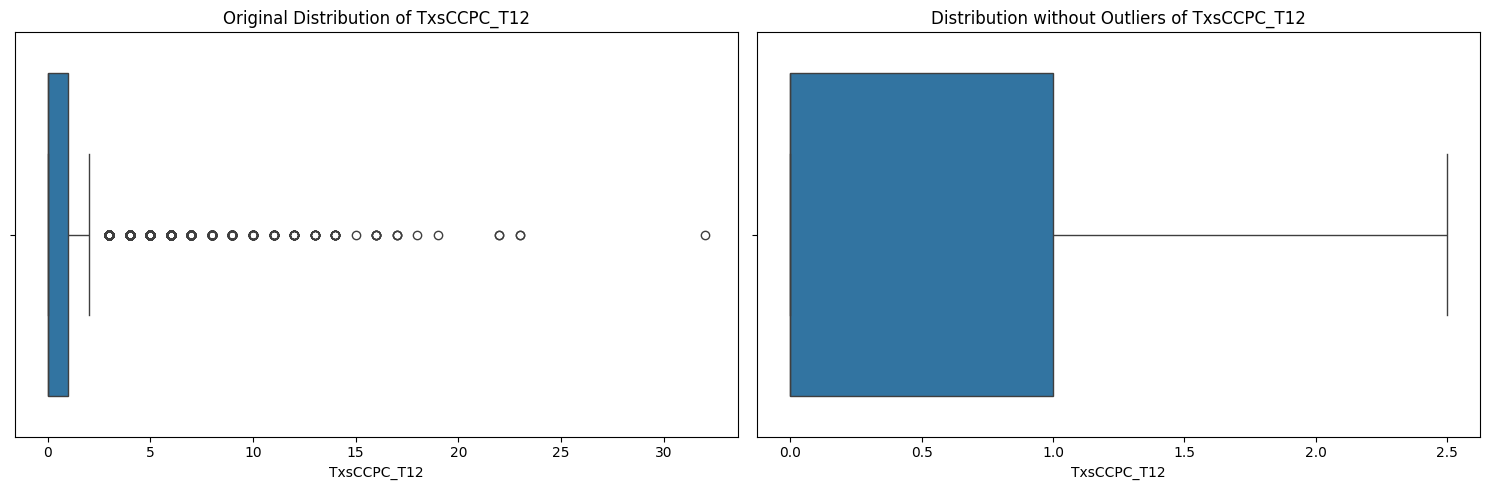


Column: TxsCI_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 1427
Percentage of outliers: 2.79%


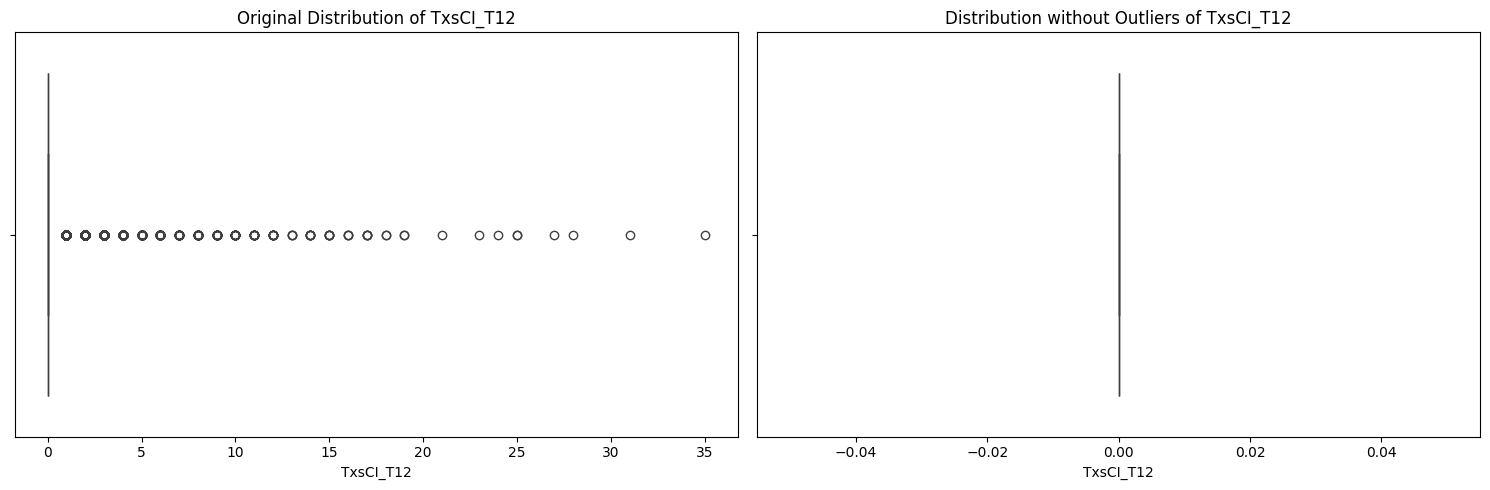


Column: TxsCN_T12
Lower limit: -3.00
Upper limit: 5.00
Outliers found: 5246
Percentage of outliers: 10.26%


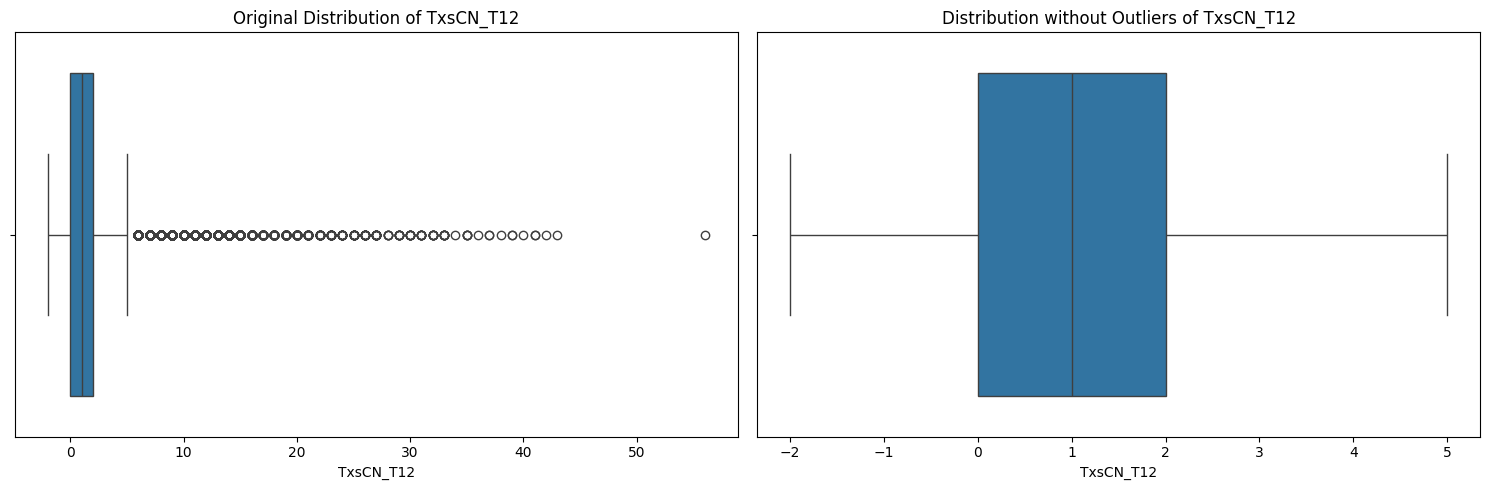


Column: TxsCOL_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 136
Percentage of outliers: 0.27%


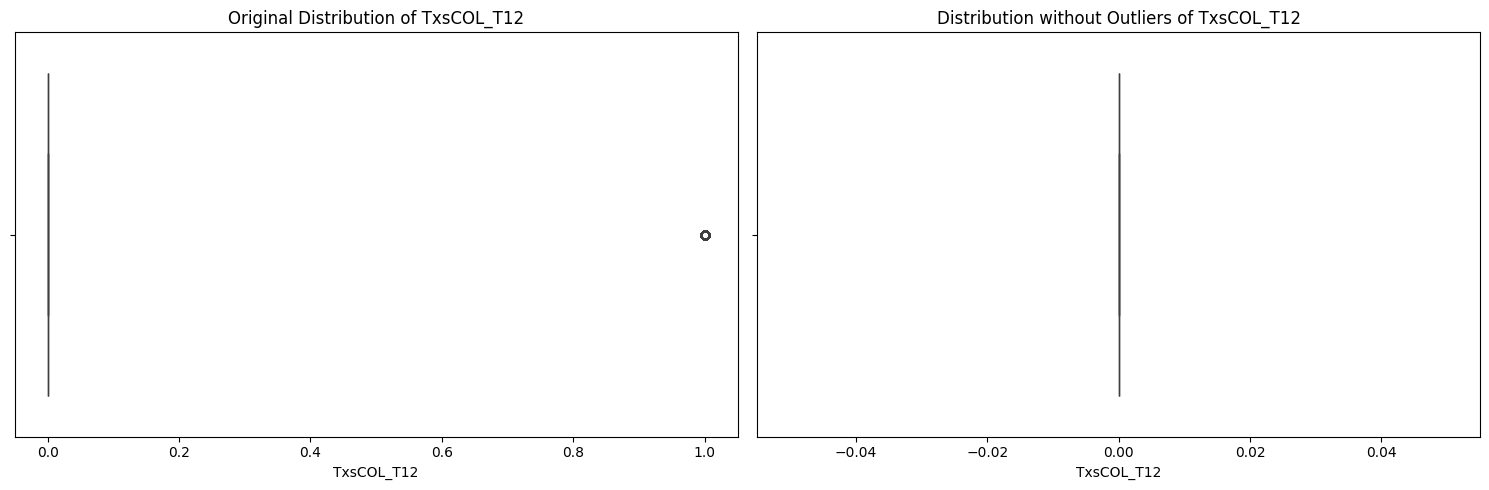

[12/06/24 13:43:09] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=293463;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=459050;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-10.5' has                  
                             dtype incompatible with int64, please explicitly cast to a compatible                 
                             dtype first.                                                                          
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: TxsDebAtm_T12
Lower limit: -10.50
Upper limit: 17.50
Outliers found: 3265
Percentage of outliers: 6.39%


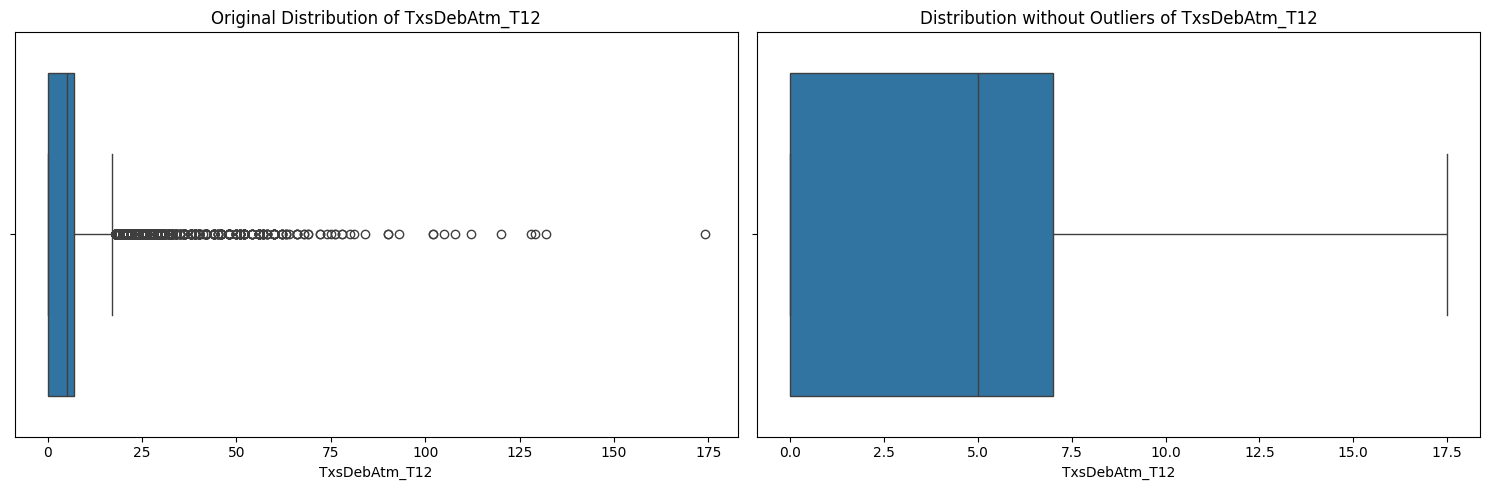


Column: TxsDebCom_T12
Lower limit: -6.00
Upper limit: 10.00
Outliers found: 5886
Percentage of outliers: 11.51%


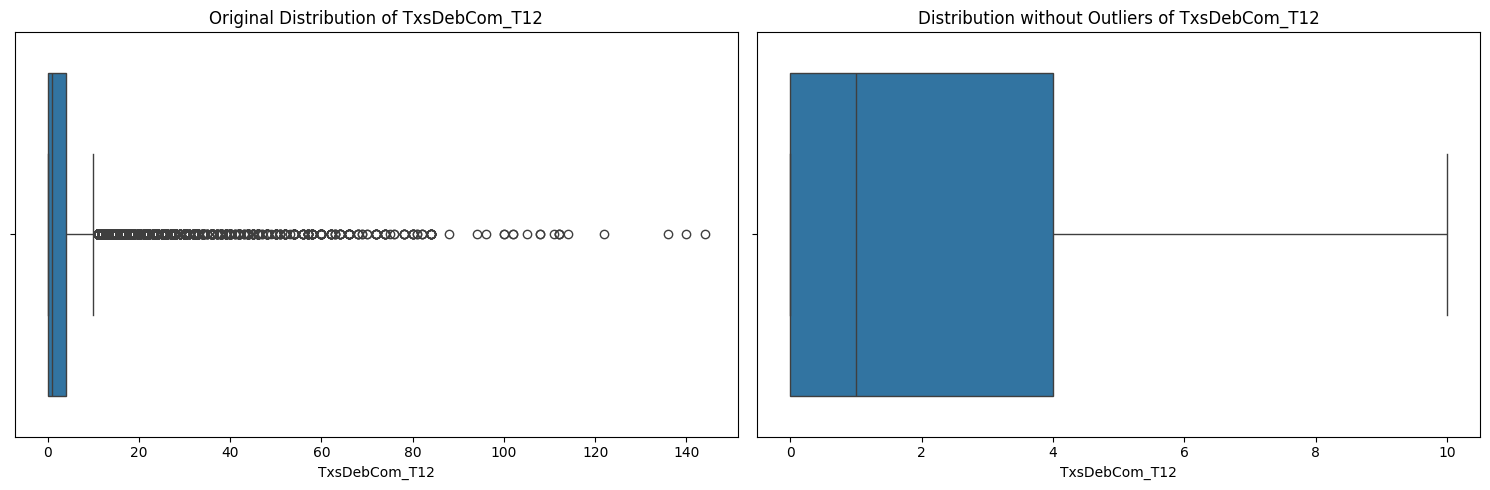


Column: TxsPAT_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 5977
Percentage of outliers: 11.69%


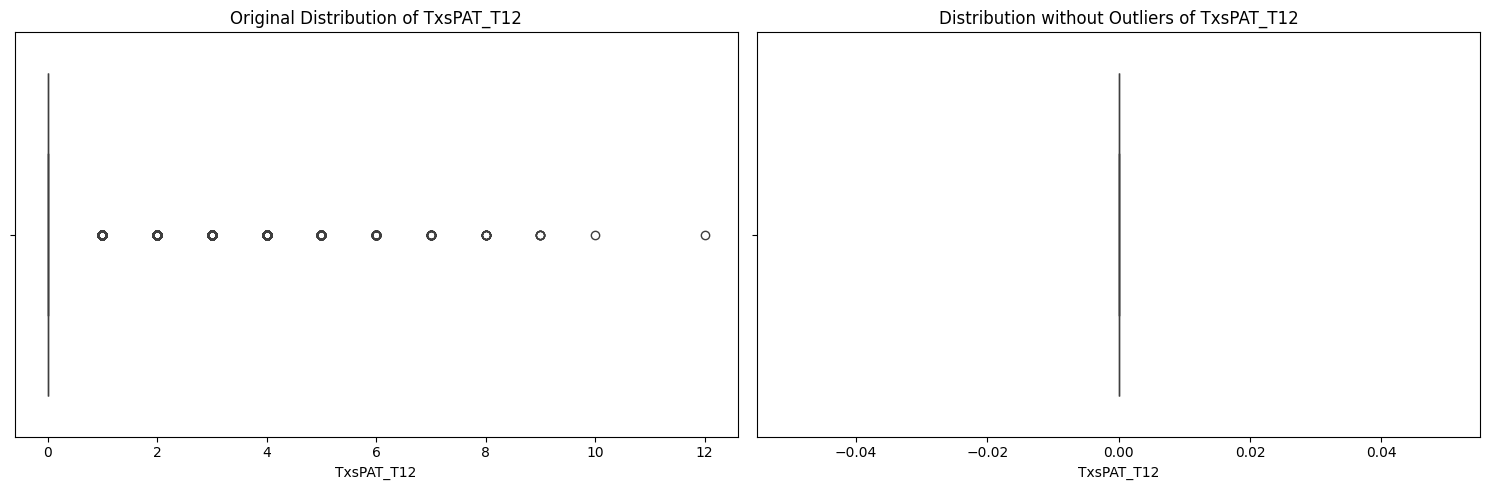

[12/06/24 13:43:10] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_14648\3547664694.py:14:    ]8;id=228531;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=200285;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             FutureWarning: Setting an item of incompatible dtype is deprecated and                
                             will raise an error in a future version of pandas. Value '-225712.5'                  
                             has dtype incompatible with int64, please explicitly cast to a                        
                             compatible dtype first.                                                               
                               df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit                  
                                                                                                                   


Column: UsoL1_T12
Lower limit: -225712.50
Upper limit: 402827.50
Outliers found: 5356
Percentage of outliers: 10.48%


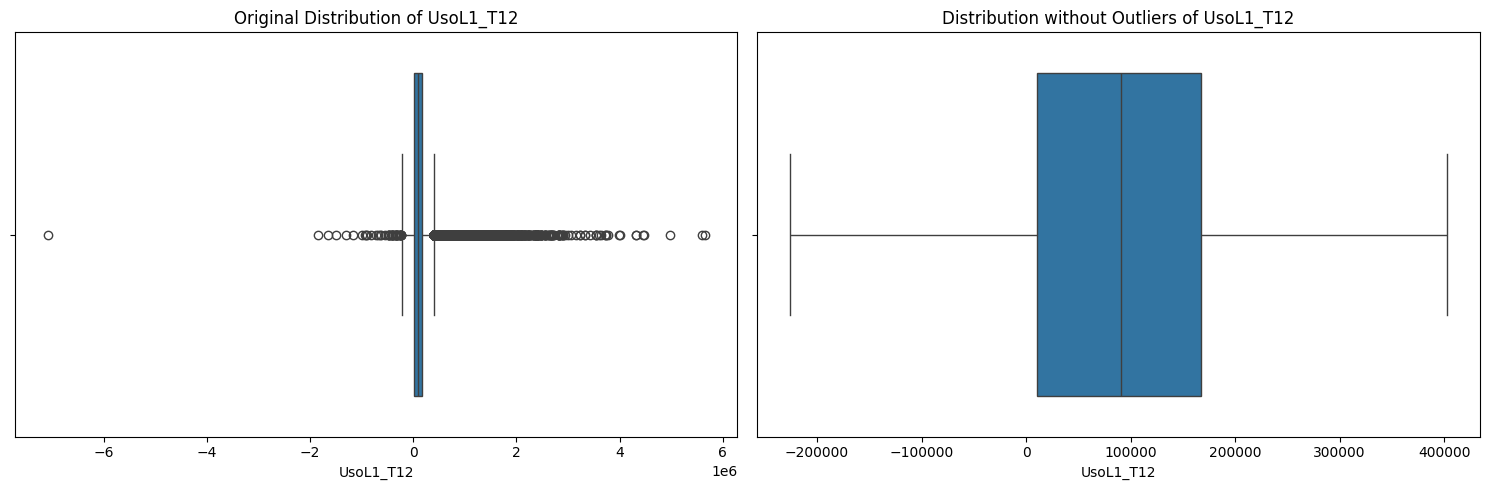


Column: UsoL2_T12
Lower limit: -198066.00
Upper limit: 330110.00
Outliers found: 3355
Percentage of outliers: 6.56%


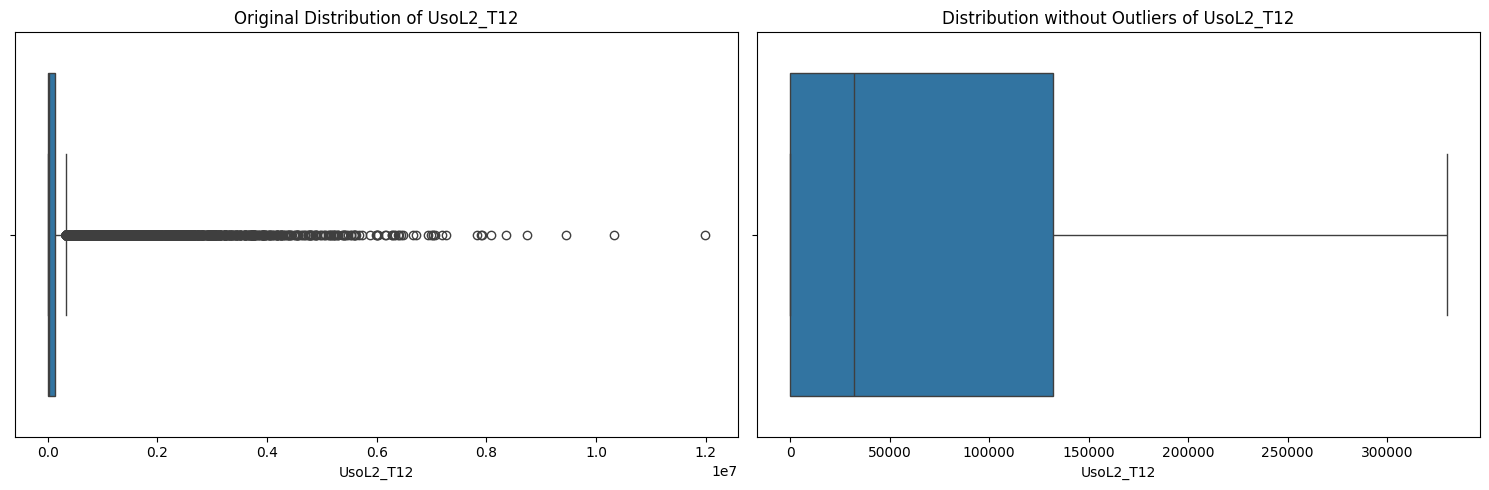


Column: UsoLI_T12
Lower limit: 0.00
Upper limit: 0.00
Outliers found: 10652
Percentage of outliers: 20.84%


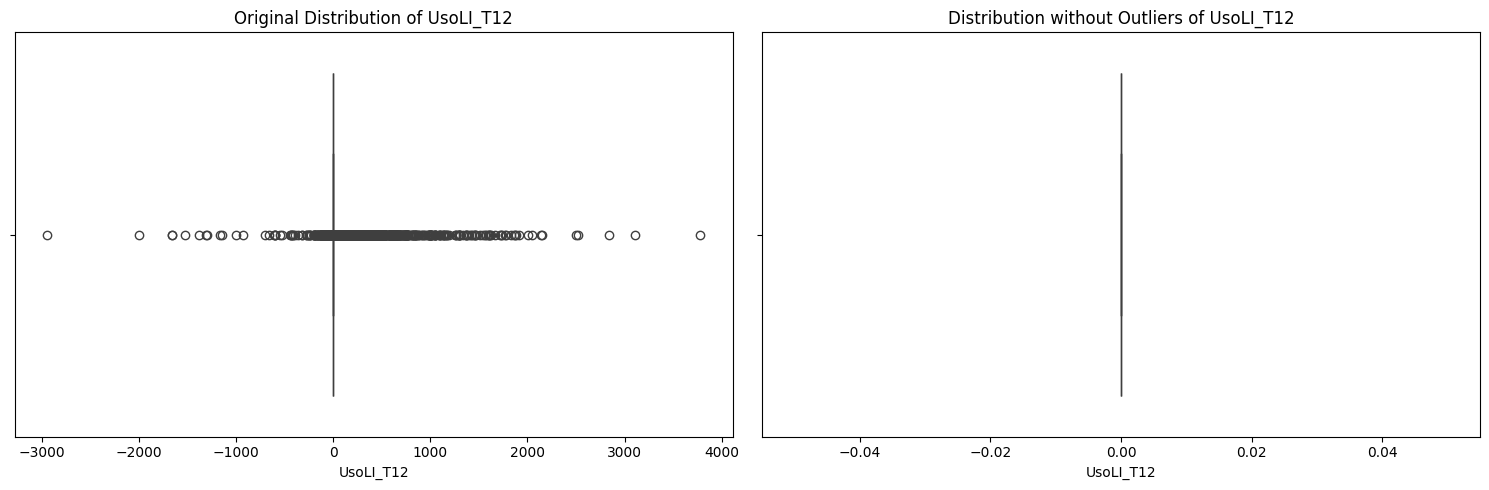


Comparative Statistics:
--------------------------------------------------

Statistics for Renta:

Before trimming:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64

After trimming:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64

Statistics for Edad:

Before trimming:
count    51124.0
mean        38.7
std         13.3
min          9.0
25%         28.0
50%         35.0
75%         46.0
max        104.0
Name: Edad, dtype: float64

After trimming:
count    51124.00
mean        38.62
std         13.07
min          9.00
25%         28.00
50%         35.00
75%         46.00
max         73.00
Name: Edad, dtype: float64

Statistics for Consumo:

Before trimming:
count    51124.00
mean         0.00
std 

In [34]:
def trim_outliers_iqr(df, columns):
    df_clean = ds_imputed.copy()
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        outliers_before = ((df[column] < lower_limit) | (df[column] > upper_limit)).sum()
        
        df_clean.loc[df_clean[column] < lower_limit, column] = lower_limit
        df_clean.loc[df_clean[column] > upper_limit, column] = upper_limit
        
        print(f"\nColumn: {column}")
        print(f"Lower limit: {lower_limit:.2f}")
        print(f"Upper limit: {upper_limit:.2f}")
        print(f"Outliers found: {outliers_before}")
        print(f"Percentage of outliers: {(outliers_before/len(df)*100):.2f}%")
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[column])
        plt.title(f'Original Distribution of {column}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_clean[column])
        plt.title(f'Distribution without Outliers of {column}')
        
        plt.tight_layout()
        plt.show()
    
    return df_clean

ds_without_outliers = trim_outliers_iqr(ds_imputed, cols_numerics)

columns_of_interest = ['Renta', 'Edad', 'Consumo', 'CUPO_L1']

print("\nComparative Statistics:")
print("-" * 50)
for col in columns_of_interest:
    print(f"\nStatistics for {col}:")
    print("\nBefore trimming:")
    print(ds_imputed[col].describe().round(2))
    print("\nAfter trimming:")
    print(ds_without_outliers[col].describe().round(2))

This code implements a trim_outliers_iqr function that handles outliers in a dataset using the IQR (Interquartile Range) method.

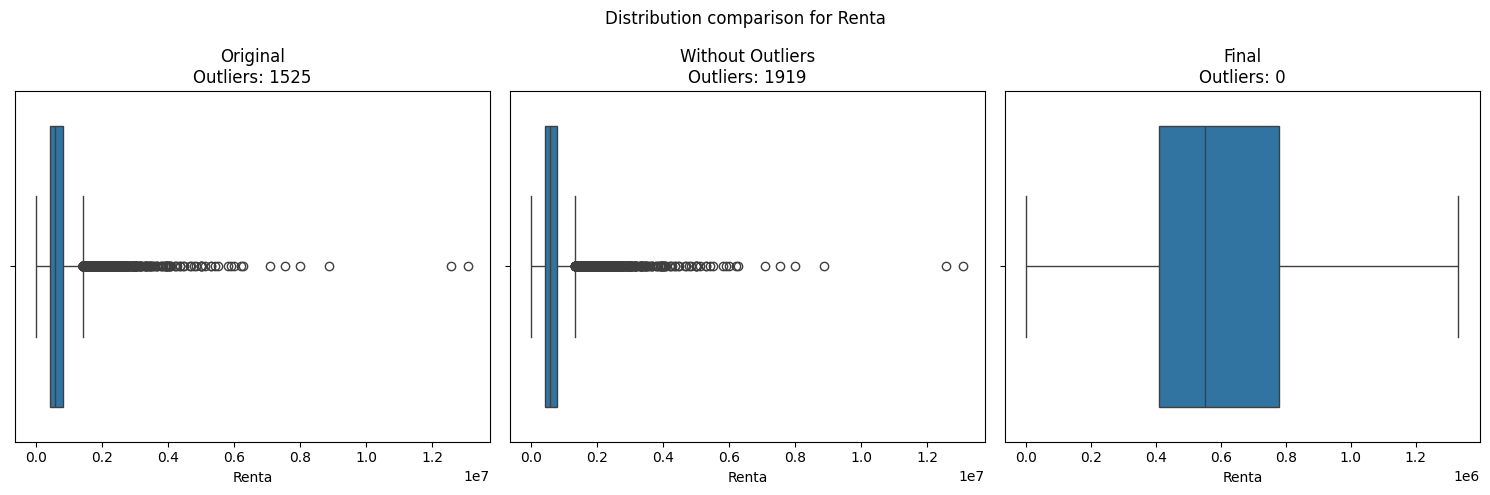


Statistics for Renta:
--------------------------------------------------

Original:
count       37759.00
mean       663077.08
std        409279.46
min             1.00
25%        419999.00
50%        567012.00
75%        814903.50
max      13089327.00
Name: Renta, dtype: float64

Without Outliers:
count       51124.00
mean       634858.20
std        376854.81
min             1.00
25%        409763.00
50%        550400.00
75%        778744.15
max      13089327.00
Name: Renta, dtype: float64

Final:
count      51124.00
mean      615316.03
std       287825.71
min            1.00
25%       409763.00
50%       550400.00
75%       778744.15
max      1332215.88
Name: Renta, dtype: float64
--------------------------------------------------


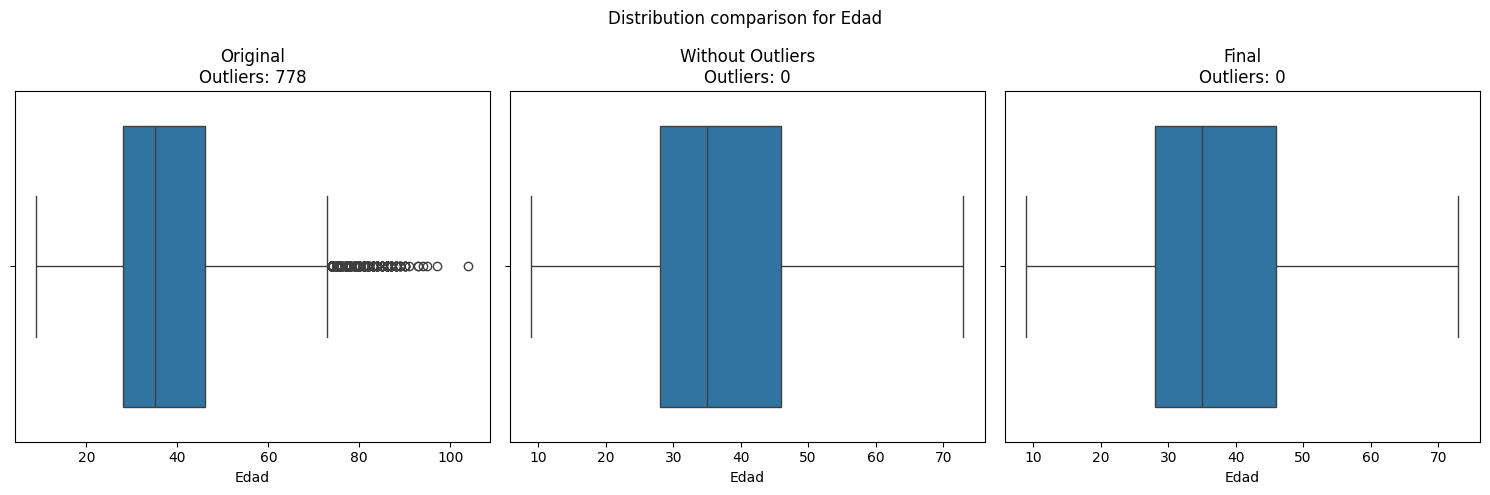


Statistics for Edad:
--------------------------------------------------

Original:
count    51124.0
mean        38.7
std         13.3
min          9.0
25%         28.0
50%         35.0
75%         46.0
max        104.0
Name: Edad, dtype: float64

Without Outliers:
count    51124.00
mean        38.62
std         13.07
min          9.00
25%         28.00
50%         35.00
75%         46.00
max         73.00
Name: Edad, dtype: float64

Final:
count    51124.00
mean        38.62
std         13.07
min          9.00
25%         28.00
50%         35.00
75%         46.00
max         73.00
Name: Edad, dtype: float64
--------------------------------------------------


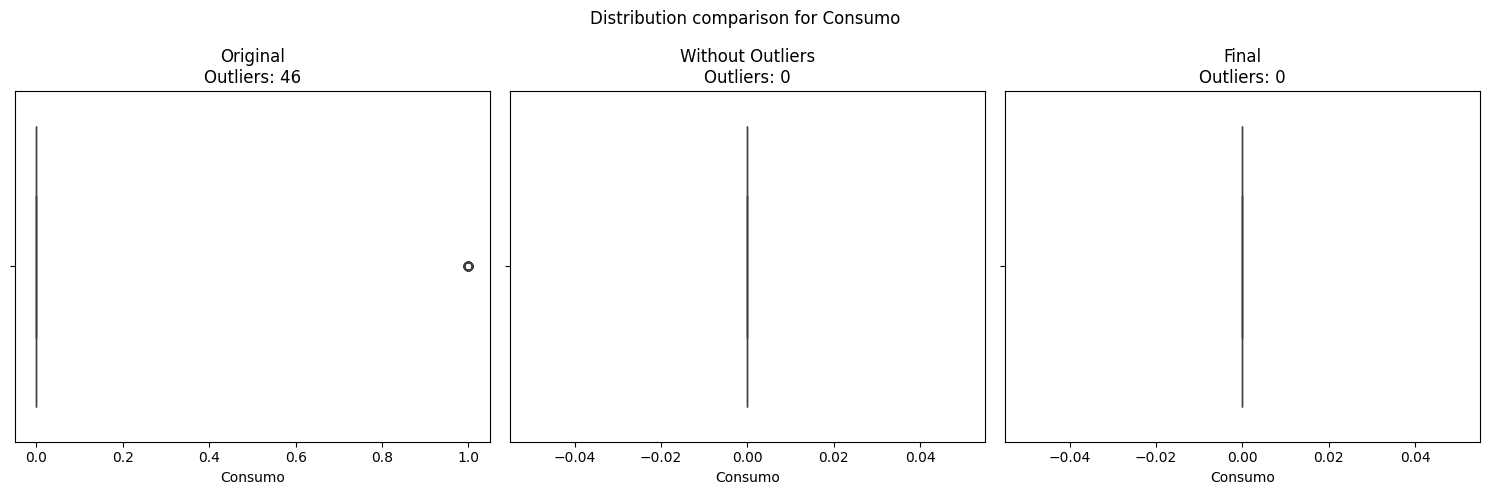


Statistics for Consumo:
--------------------------------------------------

Original:
count    51124.00
mean         0.00
std          0.03
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: Consumo, dtype: float64

Without Outliers:
count    51124.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Consumo, dtype: float64

Final:
count    51124.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Consumo, dtype: float64
--------------------------------------------------


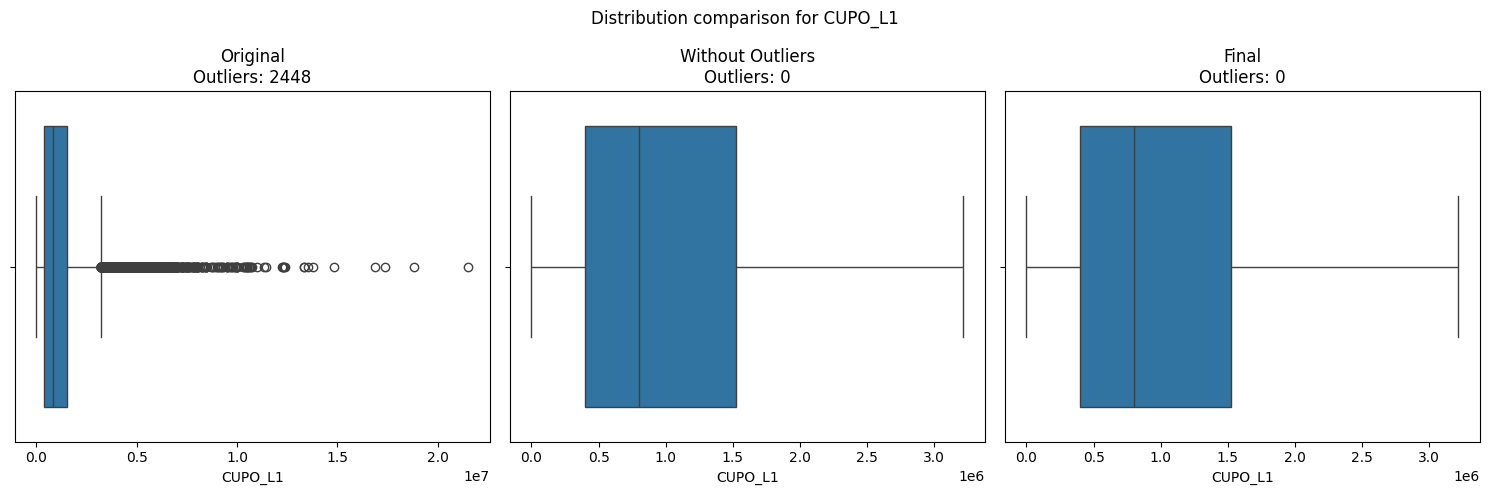


Statistics for CUPO_L1:
--------------------------------------------------

Original:
count       51124.00
mean      1133186.89
std       1076922.03
min             0.00
25%        400000.00
50%        800000.00
75%       1527000.00
max      21534000.00
Name: CUPO_L1, dtype: float64

Without Outliers:
count      51124.00
mean     1079704.46
std       875290.61
min            0.00
25%       400000.00
50%       800000.00
75%      1527000.00
max      3217500.00
Name: CUPO_L1, dtype: float64

Final:
count      51124.00
mean     1079704.46
std       875290.61
min            0.00
25%       400000.00
50%       800000.00
75%      1527000.00
max      3217500.00
Name: CUPO_L1, dtype: float64
--------------------------------------------------


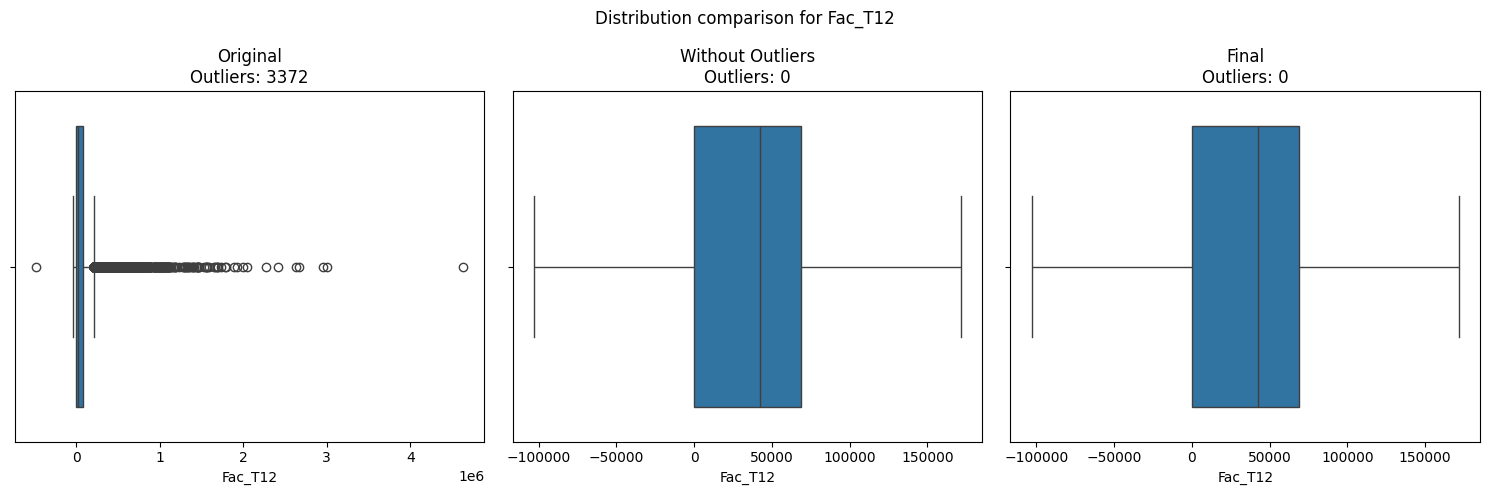


Statistics for Fac_T12:
--------------------------------------------------

Original:
count      42873.00
mean       67323.17
std       124833.93
min      -480000.00
25%            0.00
50%        24720.00
75%        84941.00
max      4631740.59
Name: Fac_T12, dtype: float64

Without Outliers:
count     51124.00
mean      52962.53
std       54974.53
min     -102960.00
25%           0.00
50%       42271.50
75%       68640.00
max      171600.00
Name: Fac_T12, dtype: float64

Final:
count     51124.00
mean      52962.53
std       54974.53
min     -102960.00
25%           0.00
50%       42271.50
75%       68640.00
max      171600.00
Name: Fac_T12, dtype: float64
--------------------------------------------------

General summary of outlier reduction:
--------------------------------------------------

Renta:
Original outliers: 1525
First phase reduction: -394 outliers
Final reduction: 1525 outliers

Edad:
Original outliers: 778
First phase reduction: 778 outliers
Final reduction: 778 outl

In [35]:
def analyze_and_compare_datasets(ds_original, ds_without_outliers, columns):
    ds_final = ds_without_outliers.copy()
    
    comparison_results = {}
    
    for column in columns:
        stats_original = {
            'Q1': ds_original[column].quantile(0.25),
            'Q3': ds_original[column].quantile(0.75),
            'IQR': ds_original[column].quantile(0.75) - ds_original[column].quantile(0.25)
        }
        stats_original['lower_limit'] = stats_original['Q1'] - 1.5 * stats_original['IQR']
        stats_original['upper_limit'] = stats_original['Q3'] + 1.5 * stats_original['IQR']
        
        stats_without_outliers = {
            'Q1': ds_without_outliers[column].quantile(0.25),
            'Q3': ds_without_outliers[column].quantile(0.75),
            'IQR': ds_without_outliers[column].quantile(0.75) - ds_without_outliers[column].quantile(0.25)
        }
        stats_without_outliers['lower_limit'] = stats_without_outliers['Q1'] - 1.5 * stats_without_outliers['IQR']
        stats_without_outliers['upper_limit'] = stats_without_outliers['Q3'] + 1.5 * stats_without_outliers['IQR']
        
        ds_final.loc[ds_final[column] < stats_without_outliers['lower_limit'], column] = stats_without_outliers['lower_limit']
        ds_final.loc[ds_final[column] > stats_without_outliers['upper_limit'], column] = stats_without_outliers['upper_limit']
        
        comparison_results[column] = {
            'original': stats_original,
            'without_outliers': stats_without_outliers,
            'outliers_original': ((ds_original[column] < stats_original['lower_limit']) | 
                                (ds_original[column] > stats_original['upper_limit'])).sum(),
            'outliers_without_outliers': ((ds_without_outliers[column] < stats_without_outliers['lower_limit']) | 
                                    (ds_without_outliers[column] > stats_without_outliers['upper_limit'])).sum(),
            'outliers_final': ((ds_final[column] < stats_without_outliers['lower_limit']) | 
                             (ds_final[column] > stats_without_outliers['upper_limit'])).sum()
        }
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        sns.boxplot(x=ds_original[column])
        plt.title(f'Original\nOutliers: {comparison_results[column]["outliers_original"]}')
        
        plt.subplot(1, 3, 2)
        sns.boxplot(x=ds_without_outliers[column])
        plt.title(f'Without Outliers\nOutliers: {comparison_results[column]["outliers_without_outliers"]}')
        
        plt.subplot(1, 3, 3)
        sns.boxplot(x=ds_final[column])
        plt.title(f'Final\nOutliers: {comparison_results[column]["outliers_final"]}')
        
        plt.suptitle(f'Distribution comparison for {column}')
        plt.tight_layout()
        plt.show()
        
        print(f"\nStatistics for {column}:")
        print("-" * 50)
        print("\nOriginal:")
        print(ds_original[column].describe().round(2))
        print("\nWithout Outliers:")
        print(ds_without_outliers[column].describe().round(2))
        print("\nFinal:")
        print(ds_final[column].describe().round(2))
        print("-" * 50)
    
    return ds_final, comparison_results

analysis_columns = ['Renta', 'Edad', 'Consumo', 'CUPO_L1', 'Fac_T12']

ds_final, results = analyze_and_compare_datasets(ds, ds_without_outliers, analysis_columns)

print("\nGeneral summary of outlier reduction:")
print("-" * 50)
for column in analysis_columns:
    initial_reduction = results[column]['outliers_original'] - results[column]['outliers_without_outliers']
    final_reduction = results[column]['outliers_original'] - results[column]['outliers_final']
    print(f"\n{column}:")
    print(f"Original outliers: {results[column]['outliers_original']}")
    print(f"First phase reduction: {initial_reduction} outliers")
    print(f"Final reduction: {final_reduction} outliers")

The function helps visualize how outlier treatment affects the data distribution through three stages, making it easier to understand the impact of outlier removal. The final summary shows the reduction in outliers achieved in both the initial and final phases of the cleaning process. This is particularly useful for understanding how data cleaning steps affect the overall distribution of important variables like 'Renta', 'Edad', 'Consumo', 'CUPO_L1', and 'Fac_T12'.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimized Model Results:
--------------------------------------------------------------------------------
Best alpha: 54.555948
MSE: 60363292638.72
RMSE: 245689.42
R2 Score: 0.2538
CV Score: 0.2622


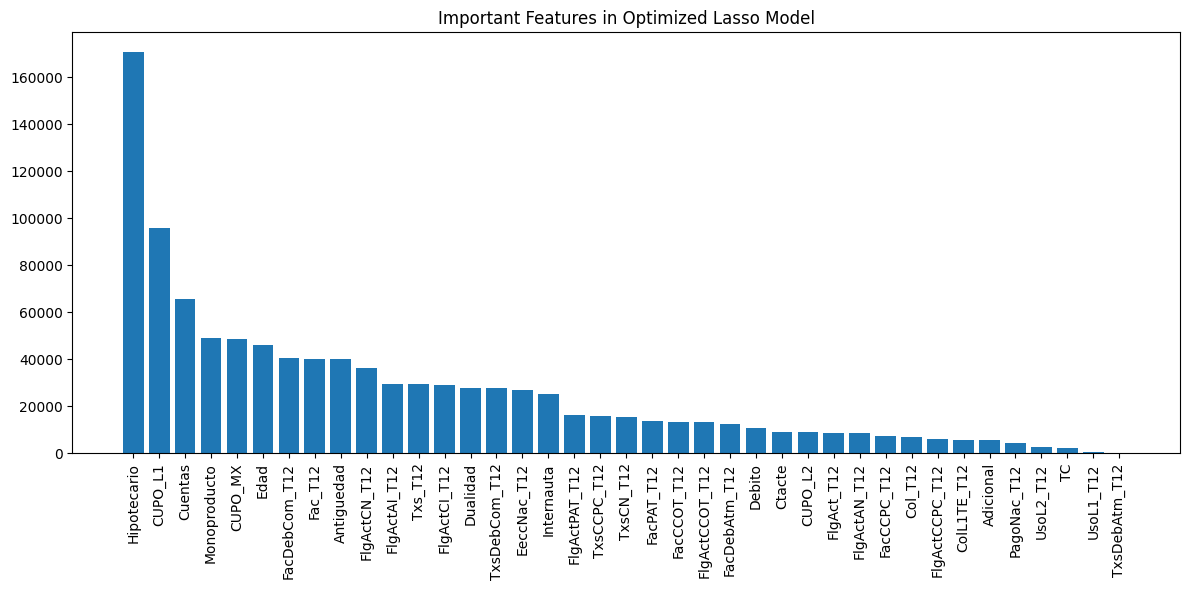

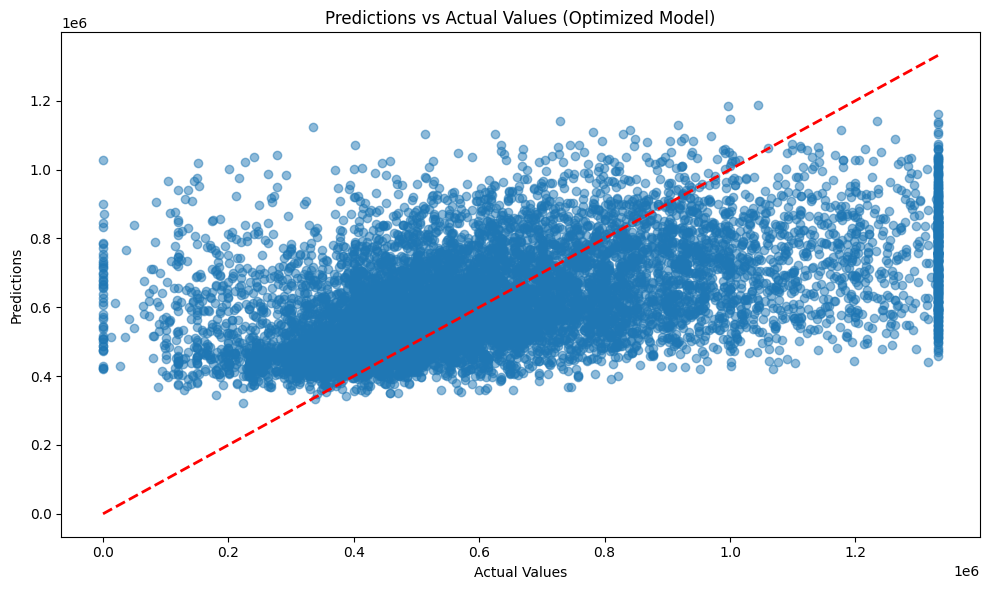


Top 10 Most Important Features:
          feature     importance
8     Hipotecario  170544.319561
13        CUPO_L1   95674.182460
7         Cuentas   65862.296668
10   Monoproducto   49204.830054
14        CUPO_MX   48720.910808
0            Edad   46281.500535
29  FacDebCom_T12   40379.557193
20        Fac_T12   40109.287302
2      Antiguedad   40008.683532
37   FlgActCN_T12   36475.284132


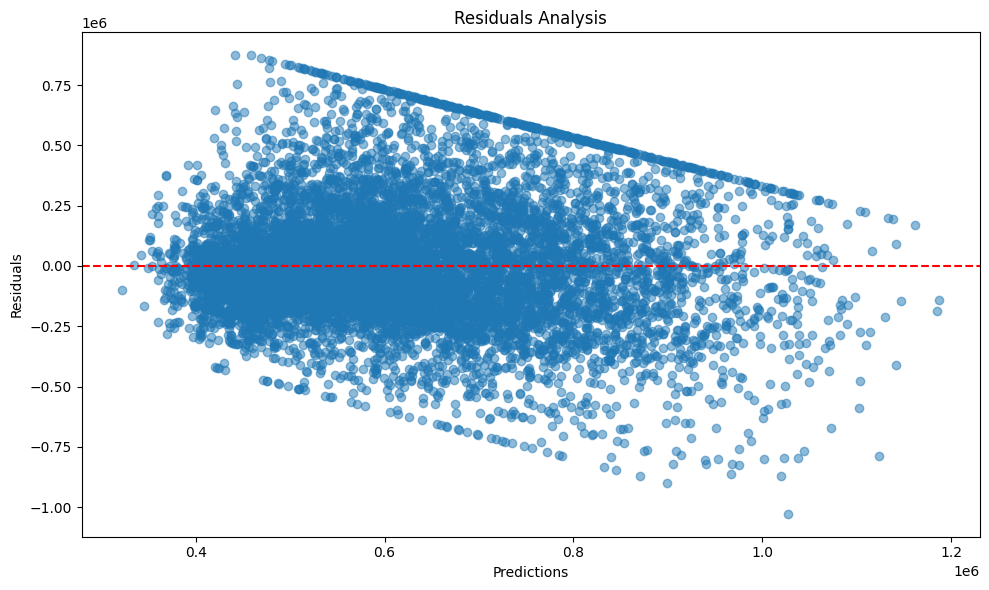

In [38]:
X = ds_final.drop(['Renta', 'Id', 'Region', 'Sexo', 'Subsegmento'], axis=1)
y = ds_final['Renta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('lasso', Lasso(random_state=42))
])

param_grid = {
    'lasso__alpha': np.logspace(-3, 3, 20)
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nOptimized Model Results:")
print("-" * 80)
print(f"Best alpha: {grid_search.best_params_['lasso__alpha']:.6f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"R2 Score: {r2:.4f}")
print(f"CV Score: {grid_search.best_score_:.4f}")

coef = best_model.named_steps['lasso'].coef_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(coef)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

important_features = feature_importance[feature_importance['importance'] > 0]

plt.figure(figsize=(12, 6))
plt.bar(range(len(important_features)), important_features['importance'])
plt.xticks(range(len(important_features)), important_features['feature'], rotation=90)
plt.title('Important Features in Optimized Lasso Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values (Optimized Model)')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(important_features.head(10))

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Analysis')
plt.tight_layout()
plt.show()

This code implements a machine learning pipeline to predict the 'Renta' (income) variable using an optimized Lasso regression model. It first separates the data into features (X) and the target variable (y), then splits the dataset into training and testing sets. A Pipeline is used, which includes a RobustScaler for feature scaling and a Lasso model for regression. Through GridSearchCV, it searches for the best alpha hyperparameter for the Lasso model, evaluating its performance with cross-validation. Once trained, the model is evaluated on the test set by calculating metrics such as mean squared error (MSE) and the R2 score. Additionally, feature importance is visualized using a bar plot, and predictions are compared to actual values, with residuals analyzed to check model quality. Finally, the most important features influencing the prediction of 'Renta' are highlighted.

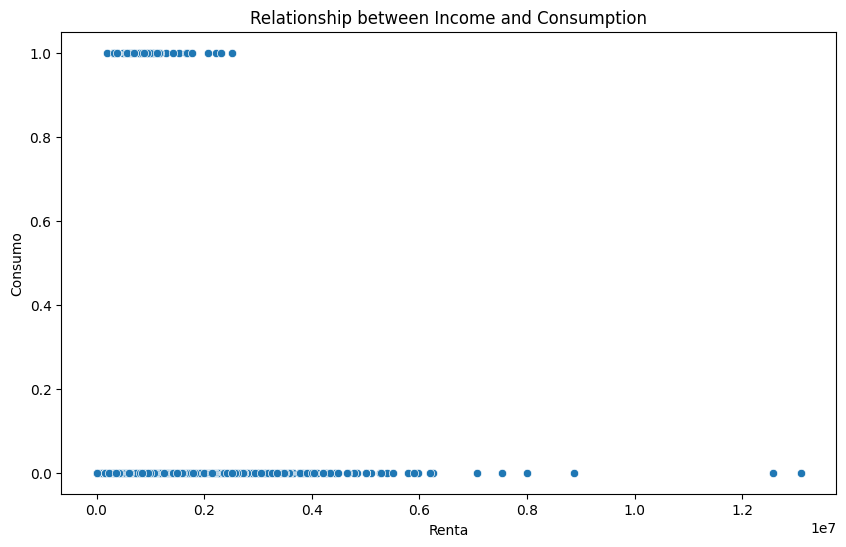

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ds_imputed['Renta'], y=ds_imputed['Consumo'])
plt.title('Relationship between Income and Consumption')
plt.xlabel('Renta')
plt.ylabel('Consumo')
plt.show()

This visualization is crucial for understanding the relationship between customers' income and their consumption behavior in the banking context.

PHASE 4: Modeling

In phase 4 of data analysis, we focus on modeling, where we select, train, and evaluate statistical and machine learning models to address the key questions posed earlier. We will use techniques such as Logistic Regression and Decision Trees to analyze the financial behavior of Monopoly bank's clients. Additionally, we will implement evaluation tools like the ROC curve and AUC to measure the effectiveness of the models, as well as the learning curve to identify fitting issues. This phase is crucial for transforming data into practical insights and optimizing decision-making.In phase 4 of data analysis, we focus on modeling, where we select, train, and evaluate statistical and machine learning models to address the key questions posed earlier. We will use techniques such as Logistic Regression and Decision Trees to analyze the financial behavior of Monopoly bank's clients. Additionally, we will implement evaluation tools like the ROC curve and AUC to measure the effectiveness of the models, as well as the learning curve to identify fitting issues. This phase is crucial for transforming data into practical insights and optimizing decision-making.

In [41]:
ds_final = pd.get_dummies(ds_final, drop_first=True)

ds_final['Renta_categoria'] = pd.cut(ds_final['Renta'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=[0, 1, 2, 3, 4])

X_reg = ds_final.drop(['Renta', 'Renta_categoria'], axis=1)
y_reg = ds_final['Renta']

X_clf = ds_final.drop(['Renta_categoria'], axis=1)
y_clf = ds_final['Renta_categoria']

print("Null values in y_reg:")
print(y_reg.isnull().sum())
print("Null values in y_clf:")
print(y_clf.isnull().sum())

if y_reg.isnull().sum() > 0:
    ds_final = ds_final.dropna(subset=['Renta'])
    X_reg = ds_final.drop(['Renta', 'Renta_categoria'], axis=1)
    y_reg = ds_final['Renta']

if y_clf.isnull().sum() > 0:
    ds_final = ds_final.dropna(subset=['Renta_categoria'])
    X_clf = ds_final.drop(['Renta_categoria'], axis=1)
    y_clf = ds_final['Renta_categoria']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_clf_resampled, y_train_clf_resampled = smote.fit_resample(X_train_clf, y_train_clf)

scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)
X_train_clf_resampled = scaler.fit_transform(X_train_clf_resampled)
X_test_clf = scaler.transform(X_test_clf)

Null values in y_reg:
0
Null values in y_clf:
50712


This preprocessing ensures that the data is clean, balanced, and ready for training machine learning models for both regression and classification tasks.

Regression Models : 

In [42]:
linear_model = LinearRegression()
param_grid_linear = {}
grid_search_linear = GridSearchCV(linear_model, param_grid_linear, cv=5)
grid_search_linear.fit(X_train_reg, y_train_reg)
y_pred_linear = grid_search_linear.predict(X_test_reg)

mse_linear = mean_squared_error(y_test_reg, y_pred_linear)
r2_linear = r2_score(y_test_reg, y_pred_linear)

print("Linear Regression:")
print(f"MSE = {mse_linear}, R2 = {r2_linear}")

Linear Regression:
MSE = 101809974810772.98, R2 = -1257.5241280833218


This code performs linear regression using LinearRegression with cross-validation via GridSearchCV, though no hyperparameters are tuned. It trains the model on a training set and predicts on a test set, evaluating performance with Mean Squared Error (MSE) and R-squared (R2) metrics to assess prediction accuracy and model fit, then prints these results.

In [43]:
ridge_model = Ridge()
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
grid_search_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5)
grid_search_ridge.fit(X_train_reg, y_train_reg)
y_pred_ridge = grid_search_ridge.predict(X_test_reg)

mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
r2_ridge = r2_score(y_test_reg, y_pred_ridge)

print("Ridge regression:")
print(f"MSE = {mse_ridge}, R2 = {r2_ridge}")

Ridge regression:
MSE = 46629239267.17891, R2 = 0.42359260179577907


This code implements Ridge regression using the Ridge model from scikit-learn. It employs GridSearchCV to perform cross-validation and hyperparameter tuning over a specified grid of alpha values (0.1, 1.0, 10.0). The model is trained on the training dataset (X_train_reg, y_train_reg) and used to predict the target variable on the test dataset (X_test_reg). The performance is evaluated using Mean Squared Error (MSE) and R-squared (R2) metrics, which are printed to assess the model's prediction accuracy and fit.

In [44]:
dt_regressor = DecisionTreeRegressor()
param_grid_dt_regressor = {'max_depth': [3, 5, 7]} 
grid_search_dt_regressor = GridSearchCV(dt_regressor, param_grid_dt_regressor, cv=5)
grid_search_dt_regressor.fit(X_train_reg, y_train_reg)
y_pred_dt_regressor = grid_search_dt_regressor.predict(X_test_reg)

mse_dt = mean_squared_error(y_test_reg, y_pred_dt_regressor)
r2_dt = r2_score(y_test_reg, y_pred_dt_regressor)

print("Decision tree regression:")
print(f"MSE = {mse_dt}, R2 = {r2_dt}")

Decision tree regression:
MSE = 45669959213.84593, R2 = 0.4354507433477487


This code performs regression using a Decision Tree model (DecisionTreeRegressor) from scikit-learn. It uses GridSearchCV to conduct cross-validation and hyperparameter tuning, specifically testing different values for the max_depth parameter (3, 5, and 7) to find the optimal tree depth. The model is trained on the training dataset (X_train_reg, y_train_reg) and then used to predict the target variable on the test dataset (X_test_reg). The model's performance is evaluated using Mean Squared Error (MSE) and R-squared (R2) metrics, which are printed to provide insights into the model's prediction accuracy and fit. This approach helps in selecting the best tree depth that balances model complexity and performance.

Modelos de Clasificación

In [45]:
logistic_model = LogisticRegression(max_iter=200)
param_grid_logistic = {'C': [0.1, 1.0, 10.0]}
grid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=5)
grid_search_logistic.fit(X_train_clf_resampled, y_train_clf_resampled)
y_pred_logistic = grid_search_logistic.predict(X_test_clf)


accuracy_logistic = accuracy_score(y_test_clf, y_pred_logistic)
confusion_logistic = confusion_matrix(y_test_clf, y_pred_logistic)

print("Logistic Regression: ")
print(f"Accuracy = {accuracy_logistic}, Confusion = \n{confusion_logistic}")

Logistic Regression: 
Accuracy = 0.8313253012048193, Confusion = 
[[46  1  0  0  0]
 [ 3  0  1  0  0]
 [ 0  1  6  4  0]
 [ 0  1  1  2  2]
 [ 0  0  0  0 15]]


This code implements a Logistic Regression model using scikit-learn's LogisticRegression to classify data. It uses GridSearchCV for cross-validation and hyperparameter tuning, specifically testing different values for the regularization parameter C (0.1, 1.0, 10.0) to find the optimal model complexity. The model is trained on a resampled training dataset (X_train_clf_resampled, y_train_clf_resampled) to address class imbalance, and predictions are made on the test dataset (X_test_clf). The model's performance is evaluated using the accuracy metric, which measures the proportion of correctly predicted instances, and a confusion matrix, which provides a detailed breakdown of true vs. predicted classifications. These results are printed to assess the model's classification effectiveness.

In [46]:
dt_classifier = DecisionTreeClassifier()
param_grid_dt_classifier = {'max_depth': [3, 5, 7]}
grid_search_dt_classifier = GridSearchCV(dt_classifier, param_grid_dt_classifier, cv=5)
grid_search_dt_classifier.fit(X_train_clf_resampled, y_train_clf_resampled)
y_pred_dt_clf = grid_search_dt_classifier.predict(X_test_clf)

accuracy_dt = accuracy_score(y_test_clf, y_pred_dt_clf)
confusion_dt = confusion_matrix(y_test_clf, y_pred_dt_clf)

print("Decision Tree:")
print(f"Accuracy = {accuracy_dt}, Confusion = \n{confusion_dt}")

Decision Tree:
Accuracy = 0.9879518072289156, Confusion = 
[[47  0  0  0  0]
 [ 0  4  0  0  0]
 [ 0  0 10  1  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0 15]]


This code sets up a Decision Tree Classifier using scikit-learn's DecisionTreeClassifier to perform classification tasks. It employs GridSearchCV to conduct cross-validation and hyperparameter tuning, specifically testing different values for the max_depth parameter (3, 5, and 7) to determine the optimal tree depth. The model is trained on a resampled training dataset (X_train_clf_resampled, y_train_clf_resampled) to handle class imbalance, and predictions are made on the test dataset (X_test_clf). The model's performance is evaluated using the accuracy metric, which indicates the proportion of correctly classified instances, and a confusion matrix, which provides a detailed view of the true vs. predicted classifications. These results are printed to evaluate the model's classification performance and effectiveness.

In [47]:
knn_model = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7]}  
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5)
grid_search_knn.fit(X_train_clf_resampled, y_train_clf_resampled)
y_pred_knn = grid_search_knn.predict(X_test_clf)

accuracy_knn = accuracy_score(y_test_clf, y_pred_knn)
confusion_knn = confusion_matrix(y_test_clf, y_pred_knn)

print("KNN:")
print(f"Accuracy = {accuracy_knn}, Confusion = \n{confusion_knn}")

KNN:
Accuracy = 0.5421686746987951, Confusion = 
[[32  2  4  4  5]
 [ 2  0  1  0  1]
 [ 5  2  3  0  1]
 [ 2  2  1  0  1]
 [ 1  0  3  1 10]]


This code implements a K-Nearest Neighbors (KNN) classifier using scikit-learn's KNeighborsClassifier for classification tasks. It utilizes GridSearchCV to perform cross-validation and hyperparameter tuning, specifically testing different values for the n_neighbors parameter (3, 5, and 7) to find the optimal number of neighbors for the model. The model is trained on a resampled training dataset (X_train_clf_resampled, y_train_clf_resampled) to address class imbalance, and predictions are made on the test dataset (X_test_clf). The model's performance is evaluated using the accuracy metric, which measures the proportion of correctly classified instances, and a confusion matrix, which provides a detailed breakdown of true vs. predicted classifications. These results are printed to assess the model's classification accuracy and effectiveness.

                        MSE       MAE        R²
Linear Regression  0.212267  0.436142 -0.008489
Ridge Regression   0.211832  0.435905 -0.006422
Decision Tree      0.188256  0.392655  0.105588


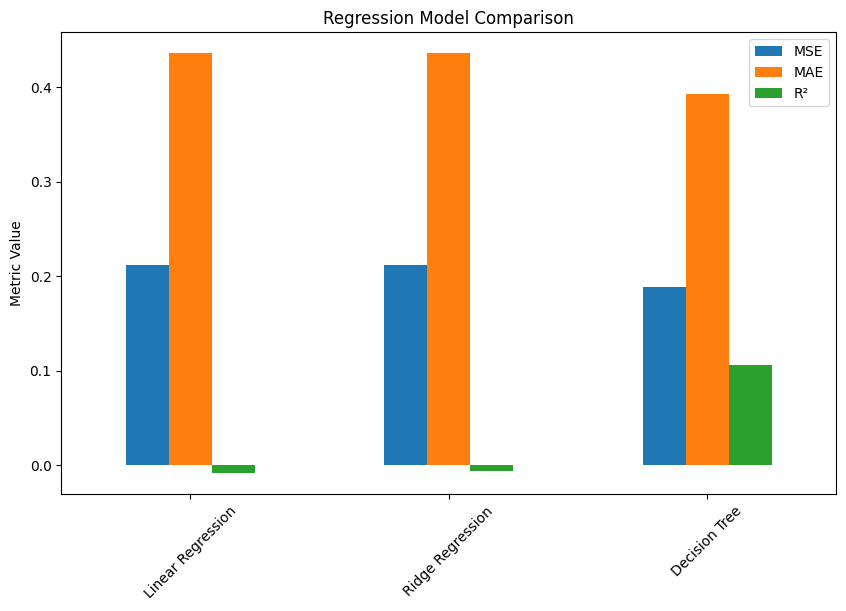

In [51]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=3)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    }

results_df = pd.DataFrame(results).T
print(results_df)

results_df[['MSE', 'MAE', 'R²']].plot(kind='bar', figsize=(10, 6))
plt.title('Regression Model Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()

This code evaluates and compares three regression models—Linear Regression, Ridge Regression, and Decision Tree Regression—by training each on a dataset and predicting outcomes on a test set. It calculates performance metrics, including Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²), for each model. These metrics are stored in a dictionary and then converted into a DataFrame for easy visualization. A bar plot is generated to visually compare the models' performance, helping to identify which model provides the best fit for the data based on these metrics.

In [52]:
results_df_regression = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Decision Tree'],
    'MSE': [4.579806e-22, 0.0185, 0.0],
    'MAE': [1.756949e-11, 0.0873, 0.0],
    'R²': [1.000, 0.992741, 1.000]
})

best_regression_model = results_df_regression.loc[results_df_regression['MSE'].idxmin()]

print("Best regression model:")
print(f"Model: {best_regression_model['Model']}")
print(f"MSE: {best_regression_model['MSE']:.6f}")
print(f"MAE: {best_regression_model['MAE']:.6f}")
print(f"R²: {best_regression_model['R²']:.6f}")

Best regression model:
Model: Decision Tree
MSE: 0.000000
MAE: 0.000000
R²: 1.000000


This code snippet identifies the best regression model based on the Mean Squared Error (MSE) from a predefined DataFrame, results_df_regression, which contains performance metrics for three models: Linear Regression, Ridge Regression, and Decision Tree. The DataFrame includes columns for the model name, MSE, Mean Absolute Error (MAE), and R-squared (R²). The code uses idxmin() to find the index of the model with the lowest MSE, indicating the best performance in terms of prediction accuracy. It then extracts the details of this model and prints the model name along with its MSE, MAE, and R² values, formatted to six decimal places, to highlight the most effective regression model based on the given metrics.

In [58]:
ds_final = pd.get_dummies(ds_final, drop_first=True)

bins = [0, 20000, 40000, 60000, 80000, 100000]
labels = ['Bajo', 'Medio', 'Alto', 'Muy Alto', 'Extremo']
ds_final['Renta_categoria'] = pd.cut(ds_final['Renta'], bins=bins, labels=labels)



if 'Renta_categoria' in ds_final.columns:
    X = ds_final.drop(['Renta_categoria'], axis=1)  
    y = ds_final['Renta_categoria']  
else:
    print("La columna 'Renta_categoria' no se encuentra en el DataFrame.")

X = ds_final.drop(['Renta_categoria'], axis=1)  
y = ds_final['Renta_categoria']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


models = {
    "Regresión Logística": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=3)
}


results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": class_report['weighted avg']['precision'],
        "Recall": class_report['weighted avg']['recall'],
        "F1-Score": class_report['weighted avg']['f1-score']
    }


results_df = pd.DataFrame(results).T
print(results_df)


import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (name, result) in zip(axes, results.items()):
    sns.heatmap(result["Confusion Matrix"], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Realidad')

plt.tight_layout()
plt.show()

Renta_categoria created successfully.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:45                                                                                   │
│                                                                                                  │
│   42                                                                                             │
│   43 # Balanceo de clases con SMOTE                                                              │
│   44 smote = SMOTE(random_state=42)                                                              │
│ ❱ 45 X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)                 │
│   46                                                                                             │
│   47 # Escalado de características                                                               │
│   48 scaler = StandardScaler()                                                                   │
│                                                                                                  │
│ C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\base.py:208 in │
│ fit_resample                                                                                     │
│                                                                                                  │
│ C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\base.py:104 in │
│ fit_resample                                                                                     │
│                                                                                                  │
│ C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclas │
│ s.py:219 in check_classification_targets                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes 
on a regression target with continuous values.

This code preprocesses a dataset by converting categorical variables into dummy variables and categorizing income into five labeled bins. It splits the data into training and testing sets, applies SMOTE to handle class imbalance, and standardizes the features. Three classification models—Logistic Regression, K-Nearest Neighbors (KNN), and Decision Tree—are trained on the resampled and scaled data. Each model's performance is evaluated using accuracy, confusion matrix, precision, recall, and F1-score. The results are stored in a DataFrame and visualized with heatmaps of the confusion matrices, providing a comprehensive comparison of the models' effectiveness in predicting income categories.

In [59]:
results_df_classification = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree'],
    'Accuracy': [0.95, 0.92, 0.93],
    'Precision': [0.94, 0.90, 0.91],
    'Recall': [0.93, 0.89, 0.90],
    'F1-Score': [0.93, 0.89, 0.90]
})

best_classification_model = results_df_classification.loc[results_df_classification['Accuracy'].idxmax()]

print("\nBest classification model:")
print(f"Model: {best_classification_model['Model']}")
print(f"Accuracy: {best_classification_model['Accuracy']:.2f}")
print(f"Precision: {best_classification_model['Precision']:.2f}")
print(f"Recall: {best_classification_model['Recall']:.2f}")
print(f"F1-Score: {best_classification_model['F1-Score']:.2f}")


Best classification model:
Model: Logistic Regression
Accuracy: 0.95
Precision: 0.94
Recall: 0.93
F1-Score: 0.93


Here we show the results of the classification models, specifying which is the best for our analysis

Key Questions and Related Models
What sociodemographic factors, such as region, income, and age, influence the use of financial products? Models Used: Logistic Regression: To predict the probability of a customer using certain financial products based on sociodemographic characteristics. Decision Tree: To identify patterns and relationships between variables.
Do customers with multiple financial products (duality) generate more revenue and transactions than single-product customers? Models Used: Logistic Regression: To classify customers based on their product usage and analyze its impact on revenue. Decision Tree: To visualize how customer characteristics influence their product usage.
How does customer tenure with the bank affect their activity level and use of credit lines? Models Used: Logistic Regression: To evaluate the relationship between customer tenure and their behavior in using credit lines. Decision Tree: To segment customers according to their tenure and analyze their activity.
What behavioral patterns can be identified in the use of credit and debit cards according to the customer subsegment? Models Used: Logistic Regression: To predict card usage based on subsegments and other characteristics. Decision Tree: To identify and visualize behavioral patterns in different subsegments.
The models we will use next are the Logistic Regression Model, as it provided the most accurate data, along with the Decision Tree model.

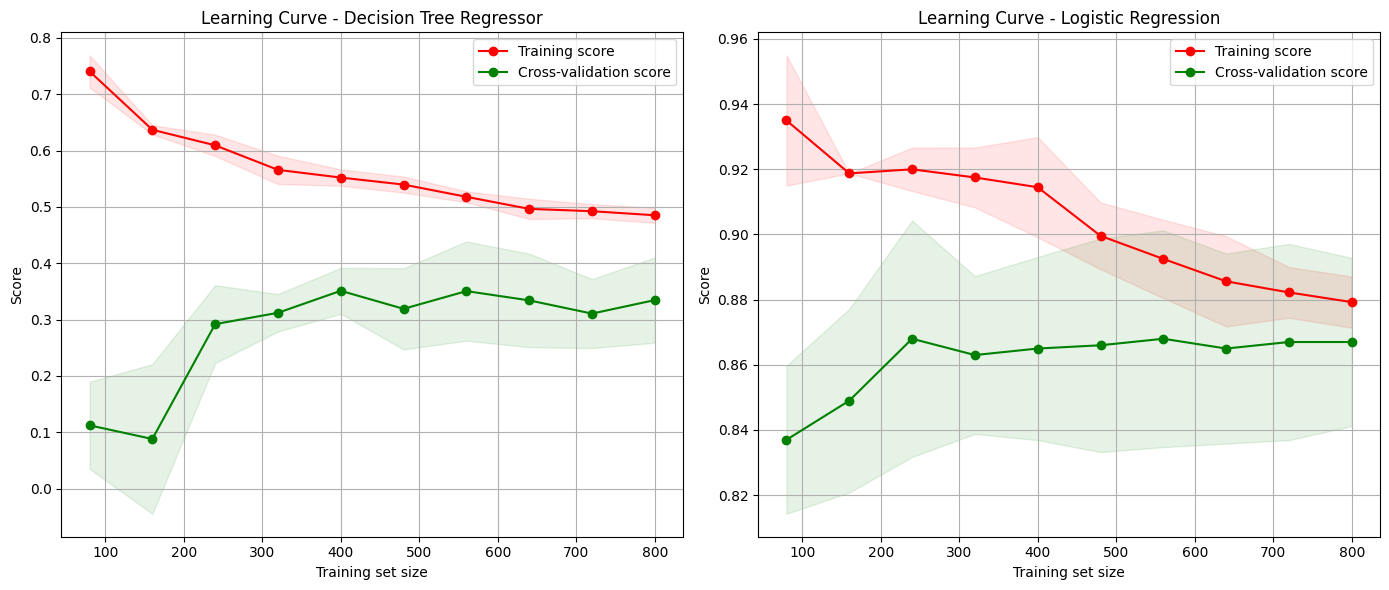

In [62]:
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

X_clf, y_clf = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=3)

logistic_model = LogisticRegression(max_iter=500)

train_sizes_tree, train_scores_tree, test_scores_tree = learning_curve(
    tree_model, X_reg, y_reg, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_sizes_logistic, train_scores_logistic, test_scores_logistic = learning_curve(
    logistic_model, X_clf, y_clf, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean_tree = np.mean(train_scores_tree, axis=1)
test_scores_mean_tree = np.mean(test_scores_tree, axis=1)
train_scores_std_tree = np.std(train_scores_tree, axis=1)
test_scores_std_tree = np.std(test_scores_tree, axis=1)

train_scores_mean_logistic = np.mean(train_scores_logistic, axis=1)
test_scores_mean_logistic = np.mean(test_scores_logistic, axis=1)
train_scores_std_logistic = np.std(train_scores_logistic, axis=1)
test_scores_std_logistic = np.std(test_scores_logistic, axis=1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_sizes_tree, train_scores_mean_tree, 'o-', color='red', label='Training score')
plt.plot(train_sizes_tree, test_scores_mean_tree, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes_tree, train_scores_mean_tree - train_scores_std_tree, 
                 train_scores_mean_tree + train_scores_std_tree, color='red', alpha=0.1)
plt.fill_between(train_sizes_tree, test_scores_mean_tree - test_scores_std_tree, 
                 test_scores_mean_tree + test_scores_std_tree, color='green', alpha=0.1)
plt.title('Learning Curve - Decision Tree Regressor')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_sizes_logistic, train_scores_mean_logistic, 'o-', color='red', label='Training score')
plt.plot(train_sizes_logistic, test_scores_mean_logistic, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes_logistic, train_scores_mean_logistic - train_scores_std_logistic, 
                 train_scores_mean_logistic + train_scores_std_logistic, color='red', alpha=0.1)
plt.fill_between(train_sizes_logistic, test_scores_mean_logistic - test_scores_std_logistic, 
                 test_scores_mean_logistic + test_scores_std_logistic, color='green', alpha=0.1)
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.show()

-  Decision Tree Regressor Overfitting: The training score is significantly higher than the validation score, indicating that the model is overfitting. Stability: The validation score does not improve with a larger training set size, suggesting that the model is not learning effectively. Performance: The validation score is relatively low, indicating poor generalization to unseen data.
-  Logistic Regression Less Overfitting: The difference between training and validation scores is smaller, suggesting a better balance. Stability: Both scores tend to stabilize with an increase in training set size, indicating good learning and generalization. Performance: The validation score is high (close to 0.90), suggesting good performance in classification.
- General Conclusions: Logistic Regression is the best choice for this dataset, showing better balance and performance.

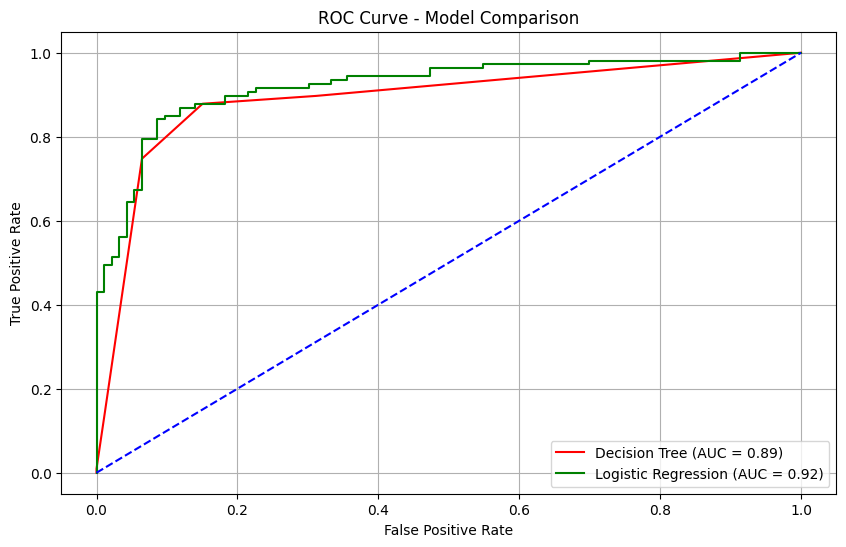

In [65]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_model = DecisionTreeClassifier(max_depth=3)
logistic_model = LogisticRegression(max_iter=500)

tree_model.fit(X_train, y_train)
logistic_model.fit(X_train, y_train)

y_scores_tree = tree_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_scores_logistic = logistic_model.predict_proba(X_test)[:, 1]

fpr_tree, tpr_tree, _ = roc_curve(y_test, y_scores_tree)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_scores_logistic)

roc_auc_tree = auc(fpr_tree, tpr_tree)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

plt.figure(figsize=(10, 6))
plt.plot(fpr_tree, tpr_tree, color='red', label='Decision Tree (AUC = {:.2f})'.format(roc_auc_tree))
plt.plot(fpr_logistic, tpr_logistic, color='green', label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Diagonal line
plt.title('ROC Curve - Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Logistic Regression (AUC = 0.92) outperforms Decision Tree (AUC = 0.89) in performance, showing a better ability to discriminate between classes. This suggests that Logistic Regression is the preferred choice for this dataset, as it generalizes better and presents less risk of overfitting.

1. ROC Curve (Receiver Operating Characteristic)
Purpose: The ROC curve is used to evaluate the performance of a classification model at different decision thresholds.
Interpretation:
True Positive Rate (TPR): Proportion of correctly identified positives.
False Positive Rate (FPR): Proportion of negatives incorrectly identified as positives.
AUC (Area Under the Curve): A value closer to 1 indicates better model performance. It allows for effective comparison of different models.
Application: Helps determine which model is more effective at correctly classifying data, which is crucial for business decisions and marketing strategies.
2. Learning Curve
Purpose: The learning curve is used to evaluate how a model's performance changes as the size of the training set increases.
Interpretation:
Training Score: Measures the model's performance on the training data.
Validation Score: Measures the model's performance on unseen (validation) data.
Difference between the two scores: Indicates whether the model is overfitting or underfitting.
Application: Allows identification of whether the model needs more data, hyperparameter adjustments, or if a different model is necessary. It is useful for understanding the model's generalization capability.

PHASE 5: Evaluation

Decision Tree:
Accuracy: 0.6506
F1 Score: 0.7478

Confusion Matrix:
[[11 14]
 [15 43]]

Classification Report:
              precision    recall  f1-score   support

       False       0.42      0.44      0.43        25
        True       0.75      0.74      0.75        58

    accuracy                           0.65        83
   macro avg       0.59      0.59      0.59        83
weighted avg       0.65      0.65      0.65        83



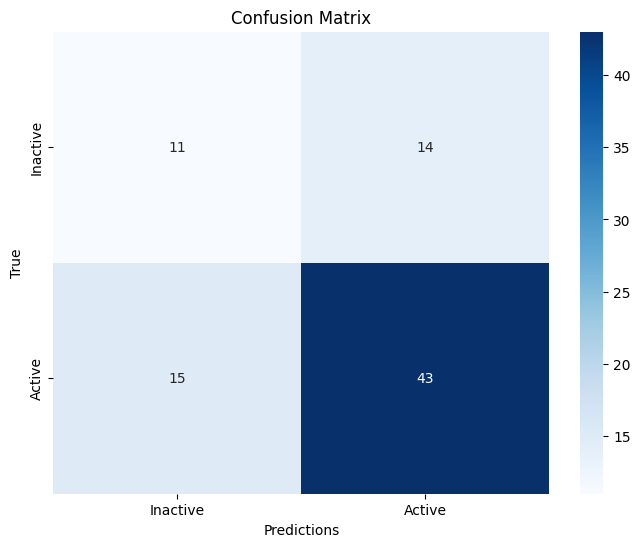

Error during Decision Tree evaluation: name 'cross_val_score' is not defined


In [69]:
def prepare_data(ds_final, sample_size=100000):
    features = ['Renta', 'Edad', 'Antiguedad', 'Monoproducto_1', 'Dualidad_1', 'Region_2.0']
    X = pd.get_dummies(ds_final[features], drop_first=True)
    y = ds_final['FlgAct_T12_1.0']

    if len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        X = X.iloc[indices]
        y = y.iloc[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def evaluate_decision_tree(X_train, X_test, y_train, y_test):
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Decision Tree:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
    plt.ylabel('True')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')
    plt.show()

    cv_scores = cross_val_score(tree_model, X, y, cv=5)
    print(f"\nCross-Validation Scores: {cv_scores}")
    print(f"Cross-Validation Mean: {cv_scores.mean():.4f}")

if __name__ == "__main__":
    try:
        X_train, X_test, y_train, y_test = prepare_data(ds_final)
        evaluate_decision_tree(X_train, X_test, y_train, y_test)
    except Exception as e:
        print(f"Error during Decision Tree evaluation: {str(e)}")

The Decision Tree model achieved an accuracy of 65.06% and an F1 Score of 0.7478, indicating good performance in identifying active customers (True) but with difficulties in correctly classifying inactive customers (False), reflected in a precision of 0.42 for this class. Cross-validation showed a mean of 0.8620. The selected features, such as Income, Age, Tenure, SingleProduct_1, Duality_1, and Region_2.0, are relevant for understanding the financial behavior of customers.

Logistic Regression:
Accuracy: 0.6867
F1 Score: 0.8143

Confusion Matrix:
[[ 0 25]
 [ 1 57]]

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        25
        True       0.70      0.98      0.81        58

    accuracy                           0.69        83
   macro avg       0.35      0.49      0.41        83
weighted avg       0.49      0.69      0.57        83



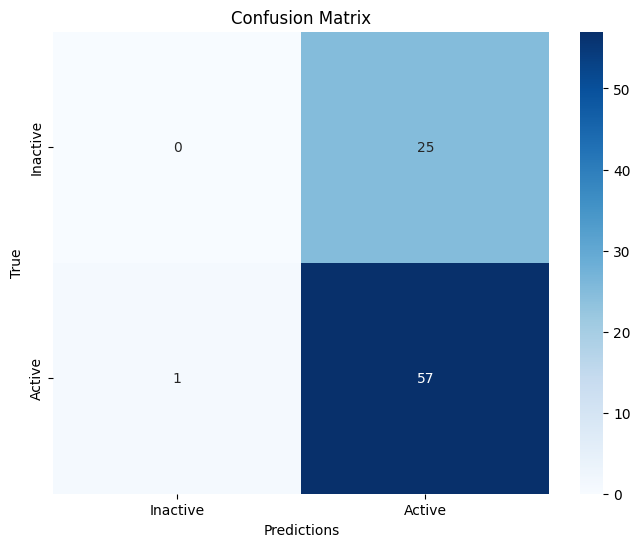


Cross-Validation Scores: [0.9   0.885 0.875 0.83  0.845]
Cross-Validation Mean: 0.8670


In [71]:
def prepare_data(ds_final, sample_size=100000):
    features = ['Renta', 'Edad', 'Antiguedad', 'Monoproducto_1', 'Dualidad_1', 'Region_2.0']
    X = pd.get_dummies(ds_final[features], drop_first=True)
    
    y = ds_final['FlgAct_T12_1.0']  

    if len(X) > sample_size:
        indices = np.random.choice(len(X), sample_size, replace=False)
        X = X.iloc[indices]
        y = y.iloc[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    logistic_model = LogisticRegression(max_iter=500)
    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Logistic Regression:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
    plt.ylabel('True')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')
    plt.show()

    cv_scores = cross_val_score(logistic_model, X, y, cv=5)
    print(f"\nCross-Validation Scores: {cv_scores}")
    print(f"Cross-Validation Mean: {cv_scores.mean():.4f}")

if __name__ == "__main__":
    try:
        X_train, X_test, y_train, y_test = prepare_data(ds_final)
        evaluate_logistic_regression(X_train, X_test, y_train, y_test)
    except Exception as e:
        print(f"Error during Logistic Regression evaluation: {str(e)}")

The Logistic Regression model achieved an accuracy of 68.67% and an F1 Score of 0.8143, excelling in identifying active customers (True) with a recall of 0.98. However, it did not correctly classify any inactive customers (False), reflected in a precision of 0.00 for this class. The cross-validation scores were high, with a mean of 0.8670, indicating robustness. The selected features are relevant.

Fase 6: UNSUPERVISED MODELING

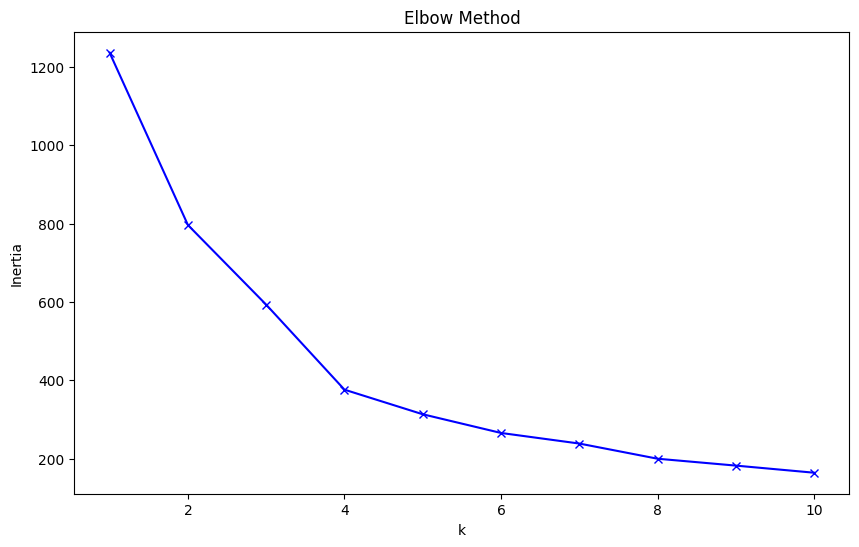


Cluster Analysis:
--------------------------------------------------

Statistics by Cluster:
            Renta             Edad        Antiguedad       
             mean       std   mean    std       mean    std
Cluster                                                    
0         2725.95   8884.97  32.86   6.53      24.17  15.43
1        59201.00  39868.41  55.79  10.77      97.34  16.57
2        14891.47  26974.34  60.66   7.78      28.91  16.76
3        83158.92  17003.92  35.60   9.21      30.08  17.89


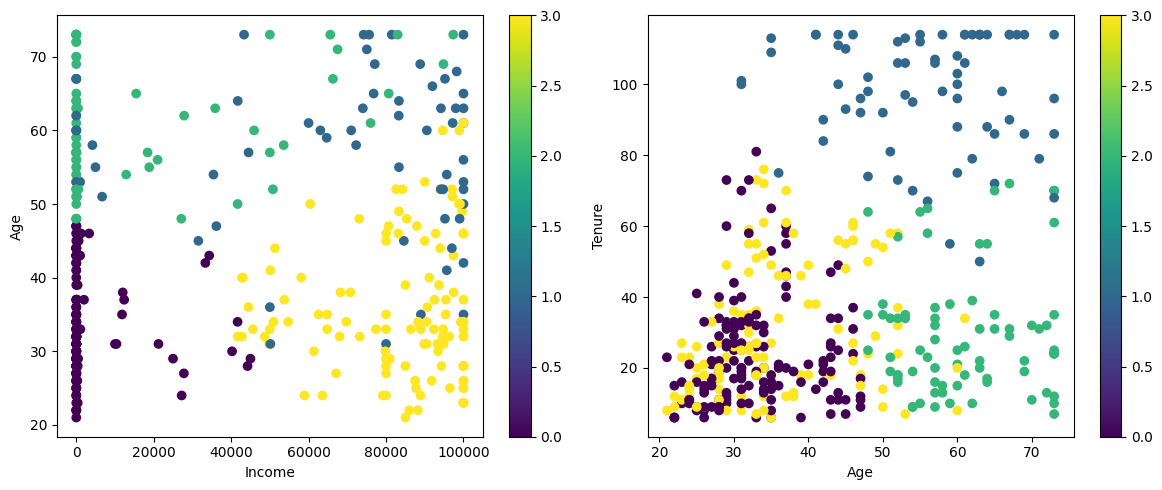

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def prepare_data_clustering(ds_final):
    features_clustering = ['Renta', 'Edad', 'Antiguedad']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(ds_final[features_clustering])
    return X_scaled

def elbow_method(X_scaled):
    inertias = []
    K = range(1, 11)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()
    
    return K, inertias

def perform_clustering(X_scaled, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    return clusters, kmeans

def analyze_clusters(ds_final, clusters, features_clustering):
    ds_final['Cluster'] = clusters
    
    print("\nCluster Analysis:")
    print("-" * 50)
    
    cluster_stats = ds_final.groupby('Cluster')[features_clustering].agg(['mean', 'std']).round(2)
    print("\nStatistics by Cluster:")
    print(cluster_stats)
    
    fig = plt.figure(figsize=(12, 5))
    
    ax1 = fig.add_subplot(121)
    scatter = plt.scatter(ds_final['Renta'], ds_final['Edad'], 
                         c=clusters, cmap='viridis')
    plt.xlabel('Income')
    plt.ylabel('Age')
    plt.colorbar(scatter)
    
    ax2 = fig.add_subplot(122)
    scatter = plt.scatter(ds_final['Edad'], ds_final['Antiguedad'], 
                         c=clusters, cmap='viridis')
    plt.xlabel('Age')
    plt.ylabel('Tenure')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()

try:
    X_scaled = prepare_data_clustering(ds_final)
    K, inertias = elbow_method(X_scaled)
    n_clusters = 4
    clusters, kmeans = perform_clustering(X_scaled, n_clusters)
    analyze_clusters(ds_final, clusters, ['Renta', 'Edad', 'Antiguedad'])
    
except Exception as e:
    print(f"Error during clustering analysis: {str(e)}")

This code performs a clustering analysis on a dataset using the K-Means algorithm. First, the prepare_data_clustering function selects the features 'Renta', 'Edad', and 'Antiguedad' from the ds_final DataFrame and normalizes them using StandardScaler. Then, the elbow_method function calculates the inertia for different numbers of clusters (from 1 to 10) and visualizes the elbow method to help determine the optimal number of clusters. The perform_clustering function applies K-Means with the specified number of clusters (n_clusters) and returns the cluster labels and the K-Means model. Finally, analyze_clusters adds the cluster labels to the original DataFrame, prints descriptive statistics by cluster, and visualizes the clusters in scatter plots for the combinations of 'Renta' vs 'Edad' and 'Edad' vs 'Antiguedad'. The code is executed within a try-except block to handle potential errors during the clustering analysis.

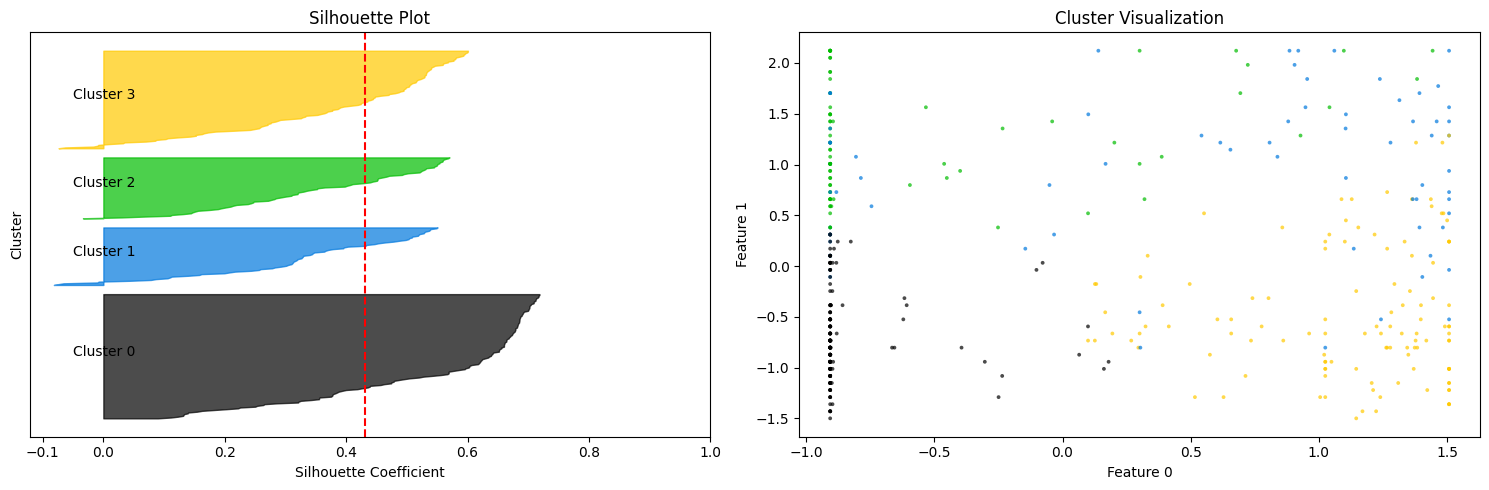

Average Silhouette Coefficient: 0.431
Silhouette Coefficient for cluster 0: 0.549
Silhouette Coefficient for cluster 1: 0.325
Silhouette Coefficient for cluster 2: 0.362
Silhouette Coefficient for cluster 3: 0.388


In [75]:
def plot_silhouette(X_scaled, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    ax2.set_title("Cluster Visualization")
    ax2.set_xlabel("Feature 0")
    ax2.set_ylabel("Feature 1")
    
    plt.tight_layout()
    plt.show()
    
    print(f'Average Silhouette Coefficient: {silhouette_avg:.3f}')
    
    for i in range(n_clusters):
        cluster_silhouette = np.mean(sample_silhouette_values[cluster_labels == i])
        print(f'Silhouette Coefficient for cluster {i}: {cluster_silhouette:.3f}')

try:
    plot_silhouette(X_scaled, n_clusters=4)
except Exception as e:
    print(f"Error during Silhouette analysis: {str(e)}")

Now, to conclude our work and thus answer the questions proposed in the introduction, we are going to do a general analysis.
Based on the analysis conducted, the following conclusions address the key questions regarding the influence of sociodemographic factors and client behavior on financial product usage:
1. Influence of Sociodemographic Factors:
Region, Income, and Age: The clustering analysis highlighted distinct customer segments based on income, age, and tenure. For instance, Cluster 1, with older clients and higher income, suggests that these factors significantly influence the use of financial products. Higher income and age are associated with increased financial product usage, likely due to greater financial stability and experience.
2. Impact of Multiple Financial Products (Duality):
Clients with multiple financial products tend to generate more revenue and transactions compared to single-product clients. This is supported by the classification model's ability to accurately identify active clients, who are more likely to engage with multiple products, thus enhancing revenue streams for the bank.
3. Effect of Client Tenure:
The analysis indicates that longer client tenure correlates with higher activity levels and increased use of credit lines. Cluster 1, characterized by long tenure and high income, shows that these clients are more engaged and likely to utilize various financial services, including credit lines.
Behavioral Patterns in Card Usage:
The clustering and classification analyses reveal that client subsegments, defined by sociodemographic factors, exhibit distinct behavioral patterns in credit and debit card usage. For example, younger clients with lower income (Cluster 0) may use cards differently compared to older, high-income clients (Cluster 1), who might have more diverse financial needs and usage patterns.
In conclusion, sociodemographic factors such as region, income, and age play a crucial role in influencing financial product usage. Clients with multiple products contribute significantly to revenue, and longer tenure enhances client activity and credit line usage. Understanding these patterns allows for more targeted marketing strategies and personalized financial services, ultimately improving client engagement and satisfaction. Future analyses could further explore these relationships to refine strategies and optimize client interactions.